## 美国职业棒球数据分析报告 1985-2015

这篇分析报告通过分析美国职业棒球大联盟的统计数据，试图获得以下几个问题的答案：
* 球队的赛季排名成绩和球队总薪资是否强相关？
* 球队的主场观众数量(Teams.csv里的attendance)和球队赛季排名成绩是否强相关？
* MLB球员的哪个年龄段是黄金年龄（拿到高薪）？
* 高薪球员的主要特点是什么？
* 球员赛季表现指标中有哪些项是强相关的？

In [1]:
START_YEAR = 1985
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

读取球队数据

In [2]:

origin_df = pd.read_csv('./baseballdatabank-master/core/Teams.csv')
print origin_df.columns
years_df = origin_df.set_index('yearID')
teams_df = origin_df.set_index('teamID')

Index([u'yearID', u'lgID', u'teamID', u'franchID', u'divID', u'Rank', u'G',
       u'Ghome', u'W', u'L', u'DivWin', u'WCWin', u'LgWin', u'WSWin', u'R',
       u'AB', u'H', u'2B', u'3B', u'HR', u'BB', u'SO', u'SB', u'CS', u'HBP',
       u'SF', u'RA', u'ER', u'ERA', u'CG', u'SHO', u'SV', u'IPouts', u'HA',
       u'HRA', u'BBA', u'SOA', u'E', u'DP', u'FP', u'name', u'park',
       u'attendance', u'BPF', u'PPF', u'teamIDBR', u'teamIDlahman45',
       u'teamIDretro'],
      dtype='object')


读取薪资数据

只处理从START_YEAR开始的赛季数据

In [3]:
salaries_df = pd.read_csv('./baseballdatabank-master/core/Salaries.csv')
salaries_df = salaries_df[salaries_df['yearID']>=START_YEAR]
print salaries_df


       yearID teamID lgID   playerID    salary
0        1985    ATL   NL  barkele01    870000
1        1985    ATL   NL  bedrost01    550000
2        1985    ATL   NL  benedbr01    545000
3        1985    ATL   NL   campri01    633333
4        1985    ATL   NL  ceronri01    625000
5        1985    ATL   NL  chambch01    800000
6        1985    ATL   NL  dedmoje01    150000
7        1985    ATL   NL  forstte01    483333
8        1985    ATL   NL  garbege01    772000
9        1985    ATL   NL  harpete01    250000
10       1985    ATL   NL  hornebo01   1500000
11       1985    ATL   NL  hubbagl01    455000
12       1985    ATL   NL  mahleri01    407500
13       1985    ATL   NL  mcmurcr01    275000
14       1985    ATL   NL  mumphje01    775000
15       1985    ATL   NL  murphda05   1625000
16       1985    ATL   NL  oberkke01    616667
17       1985    ATL   NL  perezpa01    450000
18       1985    ATL   NL  perryge01    120000
19       1985    ATL   NL  ramirra01    750000
20       1985

#### 计算球队数据的相关性

按年和球队对球队薪资数据进行分组

In [4]:
grp_salaries = salaries_df[['yearID', 'teamID', 'salary']].groupby(['yearID', 'teamID'])

观察数据特征。每一行代表一个球队在一个赛季里的数据统计

In [5]:
print grp_salaries.describe()

              salary                                                    \
               count          mean           std       min         25%   
yearID teamID                                                            
1985   ATL      22.0  6.730455e+05  3.970351e+05  120000.0   451250.00   
       BAL      22.0  5.254869e+05  3.189283e+05   60000.0   390625.00   
       BOS      25.0  4.359024e+05  2.985073e+05  115000.0   177500.00   
       CAL      28.0  5.152819e+05  3.052799e+05   60000.0   321666.75   
       CHA      21.0  4.688656e+05  3.440961e+05   60000.0   195000.00   
       CHN      22.0  5.774053e+05  3.190828e+05  200000.0   335000.25   
       CIN      22.0  3.799962e+05  3.227896e+05   60000.0   126875.00   
       CLE      20.0  3.275833e+05  2.290844e+05  110000.0   197500.00   
       DET      20.0  5.174072e+05  2.863597e+05   76000.0   250000.00   
       HOU      20.0  4.996525e+05  3.119774e+05   60000.0   294166.75   
       KCA      22.0  4.236900e+05  3.

按赛季统计每个球队：球员数量、薪资总数、标准差、中位数、最大值

In [6]:
#computed_grp_salaries_df = grp_salaries['salary'].agg([np.sum, np.std, np.mean, np.min, np.max]).reset_index()
computed_grp_salaries_df = grp_salaries['salary'].agg([pd.Series.count, np.sum, np.std, np.mean, np.max]).reset_index()
print computed_grp_salaries_df

     yearID teamID  count        sum           std          mean      amax
0      1985    ATL     22   14807000  3.970351e+05  6.730455e+05   1625000
1      1985    BAL     22   11560712  3.189283e+05  5.254869e+05   1472819
2      1985    BOS     25   10897560  2.985073e+05  4.359024e+05   1075000
3      1985    CAL     28   14427894  3.052799e+05  5.152819e+05   1100000
4      1985    CHA     21    9846178  3.440961e+05  4.688656e+05   1242333
5      1985    CHN     22   12702917  3.190828e+05  5.774053e+05   1450000
6      1985    CIN     22    8359917  3.227896e+05  3.799962e+05   1071429
7      1985    CLE     20    6551666  2.290844e+05  3.275833e+05   1100000
8      1985    DET     20   10348143  2.863597e+05  5.174072e+05   1083333
9      1985    HOU     20    9993051  3.119774e+05  4.996525e+05   1350000
10     1985    KCA     22    9321179  3.009853e+05  4.236900e+05   1000000
11     1985    LAN     23   10967917  3.275862e+05  4.768660e+05   1270000
12     1985    MIN     19

In [7]:
team_with_salaries_df = pd.merge(computed_grp_salaries_df, origin_df[['yearID', 'teamID', 'Rank', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'Ghome', 'attendance']], how='inner', on=['yearID', 'teamID']).set_index(['yearID', 'teamID'])

调整球队排名的计算。把季后赛成绩和常规赛成绩统一到一个排名字段ARank，后面以此为依据计算和排名相关的变量

In [8]:
def rank_adjust(row):
    rank = row['Rank'] + 3
    if row['WSWin'] == 'Y':
        rank -= 3
    elif row['LgWin'] == 'Y':
        rank -= 2
    return rank

team_with_salaries_df['ARank'] = team_with_salaries_df.apply(lambda row: rank_adjust(row), axis=1)
print team_with_salaries_df

               count        sum           std          mean      amax  Rank  \
yearID teamID                                                                 
1985   ATL        22   14807000  3.970351e+05  6.730455e+05   1625000     5   
       BAL        22   11560712  3.189283e+05  5.254869e+05   1472819     4   
       BOS        25   10897560  2.985073e+05  4.359024e+05   1075000     5   
       CAL        28   14427894  3.052799e+05  5.152819e+05   1100000     2   
       CHA        21    9846178  3.440961e+05  4.688656e+05   1242333     3   
       CHN        22   12702917  3.190828e+05  5.774053e+05   1450000     4   
       CIN        22    8359917  3.227896e+05  3.799962e+05   1071429     2   
       CLE        20    6551666  2.290844e+05  3.275833e+05   1100000     7   
       DET        20   10348143  2.863597e+05  5.174072e+05   1083333     3   
       HOU        20    9993051  3.119774e+05  4.996525e+05   1350000     3   
       KCA        22    9321179  3.009853e+05  4.236

In [9]:
print team_with_salaries_df.loc[2014]

        count        sum           std          mean      amax  Rank DivWin  \
teamID                                                                        
ARI        26   97861500  3.823383e+06  3.763904e+06  11000000     5      N   
ATL        24   97609000  4.779448e+06  4.067042e+06  14250000     2      N   
BAL        28  103416000  4.349065e+06  3.693429e+06  15000000     1      Y   
BOS        31  139019929  4.887357e+06  4.484514e+06  16000000     5      N   
CHA        24   81830500  4.150391e+06  3.409604e+06  15000000     4      N   
CHN        27   65522500  2.446508e+06  2.426759e+06  11000000     5      N   
CIN        28  108217500  3.914747e+06  3.864911e+06  12000000     4      N   
CLE        26   82151899  4.192258e+06  3.159688e+06  15000000     3      N   
COL        30   95403500  4.090896e+06  3.180117e+06  16000000     4      N   
DET        23  152855500  7.276494e+06  6.645891e+06  22000000     1      Y   
HOU        20   35116300  2.888056e+06  1.755815e+06

根据问题，在球队数据中的计算相关度

用pearson相关度方法计算球队总薪资和排名的关系。（*上个版本的计算方法错了，因为每个赛季的薪资水平都有调整，应当按赛季计算相关度更合理！！*）

In [10]:
year_salaries_df = salaries_df.set_index('yearID')
def calc_corr_per_season(df, col1, col2):
    #get columns and make new dataframe, then group by 'yearID' to calculate year group corr
    gdf = df.reset_index('yearID')[['yearID', col1, col2]].groupby('yearID')
    corr_df = gdf.corr()
    #dataframe.corr() get a new dataframe to store all keys corr, because we groupby yearID, so it meaning corr with 'col1' and 'col2' per year.
    #so get mean from the corr dataframe
    return corr_df.filter(like=col2, axis=0)[col1].mean()
    


In [11]:
#print 'arank corr team salaries:', team_with_salaries_df['ARank'].corr(team_with_salaries_df['sum'])
print 'arank corr team salaries:', calc_corr_per_season(team_with_salaries_df, 'ARank', 'sum')

arank corr team salaries: -0.31319191982069067


用pearson相关度方法计算球队主场场次数和排名的关系

In [12]:
print 'arank corr team Ghome', team_with_salaries_df['ARank'].corr(team_with_salaries_df['Ghome'])

arank corr team Ghome 0.01835080577818804


用pearson相关度方法计算球队主场观众数和排名的关系

In [13]:
print 'arank corr team home attendances', team_with_salaries_df['ARank'].corr(team_with_salaries_df['attendance'])

arank corr team home attendances -0.43365848054058775


用pearson相关度方法计算球队总薪资和球队主场观众数的关系。（*上个版本的计算方法错了，因为每个赛季的薪资水平都有调整，应当按赛季计算相关度更合理！！*）

In [14]:
#print 'salaries corr team home attendances', team_with_salaries_df['sum'].corr(team_with_salaries_df['attendance'])
print 'salaries corr team home attendances', calc_corr_per_season(team_with_salaries_df, 'attendance', 'sum')

salaries corr team home attendances 0.6440354974352555


用pearson相关度方法计算球队排名和球队球员数量的关系

In [15]:
print 'arank corr team players:', team_with_salaries_df['ARank'].corr(team_with_salaries_df['count'])

arank corr team players: 0.015906237476913002


计算累计薪资投入和球队赛季排名成绩的关系

计算几个赛季的年均投入，并加到dataframe中作为新的一列

In [16]:
def rolling_years_corr(rolling_size, team_with_salaries_df):
    team_with_salaries_df_sal = team_with_salaries_df['sum']
    team_with_salaries_df[str(rolling_size)+'ysal_avg'] = team_with_salaries_df_sal.rolling(rolling_size).mean()
    team_with_salaries_df_arank = team_with_salaries_df['ARank']
    team_with_salaries_df[str(rolling_size)+'yarank_avg'] = team_with_salaries_df_arank.rolling(rolling_size).mean()

计算3年和5年的年均投入

In [17]:
rolling_years_corr(3, team_with_salaries_df)
rolling_years_corr(5, team_with_salaries_df)
print team_with_salaries_df.loc[2014]

        count        sum           std          mean      amax  Rank DivWin  \
teamID                                                                        
ARI        26   97861500  3.823383e+06  3.763904e+06  11000000     5      N   
ATL        24   97609000  4.779448e+06  4.067042e+06  14250000     2      N   
BAL        28  103416000  4.349065e+06  3.693429e+06  15000000     1      Y   
BOS        31  139019929  4.887357e+06  4.484514e+06  16000000     5      N   
CHA        24   81830500  4.150391e+06  3.409604e+06  15000000     4      N   
CHN        27   65522500  2.446508e+06  2.426759e+06  11000000     5      N   
CIN        28  108217500  3.914747e+06  3.864911e+06  12000000     4      N   
CLE        26   82151899  4.192258e+06  3.159688e+06  15000000     3      N   
COL        30   95403500  4.090896e+06  3.180117e+06  16000000     4      N   
DET        23  152855500  7.276494e+06  6.645891e+06  22000000     1      Y   
HOU        20   35116300  2.888056e+06  1.755815e+06

用pearson相关度方法计算球队5年年均总薪资和排名的关系。实际上是评估球队稳定的投入的情况下，对球队会有多大影响（*上个版本的计算方法错了，因为每个赛季的薪资水平都有调整，应当按赛季计算相关度更合理！！*）

In [18]:
#print 'arank corr team Ghome rolling 5 years', team_with_salaries_df['5yarank_avg'].corr(team_with_salaries_df['5ysal_avg'])
print 'arank corr team Ghome rolling 5 years', calc_corr_per_season(team_with_salaries_df, '5yarank_avg', '5ysal_avg')

arank corr team Ghome rolling 5 years -0.31628959025896247


用pearson相关度方法计算球队3年年均总薪资和排名的关系。（*上个版本的计算方法错了，因为每个赛季的薪资水平都有调整，应当按赛季计算相关度更合理！！*）

In [19]:
#print 'arank corr team Ghome rolling 3 years', team_with_salaries_df['3yarank_avg'].corr(team_with_salaries_df['3ysal_avg'])
print 'arank corr team Ghome rolling 3 years', calc_corr_per_season(team_with_salaries_df, '3yarank_avg', '3ysal_avg')

arank corr team Ghome rolling 3 years -0.32835515385610825


绘制图形

*以下是上个版本绘制的图形，对分析帮助不大注释掉。*

把数据拆分成10年的粒度

In [20]:
# def get_index_min_max(df, index_label):
#     index = df.index.get_level_values(index_label)
#     if index.dtype.kind != 'i':
#         raise 'index isnot ingeter type!'
#     min_val = index.min()
#     max_val = index.max()
#     return min_val, max_val
    
# def divide_by_index_size(size, index_label, df):
#     min_val, max_val = get_index_min_max(df, index_label)
#     df_list = []
#     #size used as range step, so we can divide data by it 
#     for i in range(min_val, max_val, size):
#         df_list.append(df.loc[pd.IndexSlice[i:i+size]])
#     return df_list

# team_with_salaries_df_10years = divide_by_index_size(10, 'yearID', team_with_salaries_df)
# team_with_salaries_df_10years.reverse()

# print 'team_with_salaries_df_10years items: ', len(team_with_salaries_df_10years)

绘制MLB从1985年开始的球队薪资变化stack图形

观察结果：从1985年到2015年薪资增长了约17倍

In [21]:
# def draw_barh_with_team_salaries(df, title):
#     min_year, max_year = get_index_min_max(df, 'yearID')
#     title = '%s %d-%d'%(title, min_year, max_year)
#     salaries_df = df[['sum']].reset_index()
#     draw_df = salaries_df.pivot(index='yearID', columns='teamID', values='sum')
#     draw_df.plot.barh(figsize=(16, 25), grid=True, stacked=True, title=title)
    
# for df in team_with_salaries_df_10years:
#     draw_barh_with_team_salaries(df, 'team salaries')

按年绘制球队总薪资和赛季排名的scatter

In [22]:
# def draw_scatter_with_team_salaries(df, title):
#     min_year, max_year = get_index_min_max(df, 'yearID')
#     title = '%s %d-%d'%(title, min_year, max_year)
#     #restore index column 'yearID'
#     salaries_df = df[['ARank','sum']].reset_index()
#     salaries_df = salaries_df.rename(index=str, columns={'sum':'salaries'})
#     #ARank as y-axis, yearID as x-axis
#     salaries_df.plot.scatter(x='yearID', y='ARank', s=salaries_df.salaries/500000,
#                              figsize=(16, 25), grid=True,
#                              title=title)
    
# for df in team_with_salaries_df_10years:
#     draw_scatter_with_team_salaries(df, 'team rank with salaries')

绘制按赛季的球队主场观众数的stack图

观察结果：从1985年到2015年主场观众人数增长约1.7倍

In [23]:
# def draw_barh_with_team_attendance(df, title):
#     min_year, max_year = get_index_min_max(df, 'yearID')
#     title = '%s %d-%d'%(title, min_year, max_year)
#     attendances_df = df[['attendance']].reset_index()
#     draw_df = attendances_df.pivot(index='yearID', columns='teamID', values='attendance')
#     draw_df.plot.barh(figsize=(16, 25), grid=True, stacked=True, title=title)
    
# for df in team_with_salaries_df_10years:
#     draw_barh_with_team_attendance(df, 'team attendance')

绘制球队主场观众数量和排名的scatter图形



In [24]:
# def draw_scatter_with_team_attendance(df, title):
#     min_year, max_year = get_index_min_max(df, 'yearID')
#     title = '%s %d-%d'%(title, min_year, max_year)
#     salaries_df = df[['ARank','attendance']].reset_index()
    
    
#     salaries_df.plot.scatter(x='yearID', y='ARank', s=salaries_df.attendance/10000,
#                              figsize=(16, 25), grid=True,
#                              title=title)
    
# for df in team_with_salaries_df_10years:
#     draw_scatter_with_team_attendance(df, 'team rank with attendance')

### 问题1:球队的赛季排名成绩和球队总薪资是否强相关？

首先统计总排名，把季后赛的成绩也计算进来。计算的方法是把季后赛的每个阶段都作为1级RANK，总共增加3级RANK，作为ARANK字段。RANK是越小越排名越高。因此薪资和排名的相关性的值应当是负值。

计算结果表明当赛季薪资和当赛季排名不是强相关：

    arank corr team salaries: -0.31319191982069067

如果计算近5年平均薪资和近3年平均薪资则相关度更高，但也不是左右赛季排名的决定因素：

    arank corr team with rolling 5 years -0.31628959025896247


    arank corr team with rolling 3 years -0.32835515385610825


#### 因此本问题的答案是赛季排名和球队总薪资不是强相关



### 问题2:球队的主场观众数量(Teams.csv里的attendance)和球队赛季排名成绩是否强相关？

计算结果表明赛季排名成绩和主场观众数有一定的相关，有43%的相关度，也不是强相关。

    arank corr team home attendances -0.4336584805405877
    
但是计算的另外一个变量球队总薪酬对主场观众数是强相关的影响。表明明星球员能够显著的吸引更多的观众前来观看比赛

    salaries corr team home attendances 0.6440354974352555

#### 因此本问题的答案是赛季排名和主场观众人数不是强相关。但是球队总薪酬和主场观众人数是相关度较高达到 0.6440354974352555。






#### 计算球员数据的相关性

计算球员的年龄/BMI等参数

In [25]:
def add_player_attrs(salaries_df, player_df):
    df = salaries_df.join(player_df[['birthYear', 'weight', 'height']], on='playerID', how='inner', rsuffix='_p')
    df['bmi'] = df.apply(lambda row: (row['weight']/(row['height']*row['height']))*703, axis=1)
    return df;
                            
def calc_player_age_to_salaries_table(salaries_df):
    return salaries_df.apply(lambda row: row['yearID']-row['birthYear'], axis=1)

salaries_df = add_player_attrs(salaries_df, pd.read_csv('./baseballdatabank-master/core/Master.csv').set_index('playerID'))
salaries_df['age'] = calc_player_age_to_salaries_table(salaries_df)



In [26]:
salaries_df[['birthYear', 'age']] = salaries_df[['birthYear', 'age']].astype('int')
year_salaries_df = salaries_df.set_index('yearID')
print year_salaries_df

       teamID lgID   playerID   salary  birthYear  weight  height        bmi  \
yearID                                                                         
1985      ATL   NL  barkele01   870000       1955   225.0    77.0  26.678192   
1986      ATL   NL  barkele01   880000       1955   225.0    77.0  26.678192   
1987      ATL   NL  barkele01   890000       1955   225.0    77.0  26.678192   
1987      ML4   AL  barkele01    72500       1955   225.0    77.0  26.678192   
1988      ATL   NL  barkele01   900000       1955   225.0    77.0  26.678192   
1985      ATL   NL  bedrost01   550000       1957   200.0    75.0  24.995556   
1986      PHI   NL  bedrost01   650000       1957   200.0    75.0  24.995556   
1987      PHI   NL  bedrost01  1050000       1957   200.0    75.0  24.995556   
1988      PHI   NL  bedrost01   925000       1957   200.0    75.0  24.995556   
1989      PHI   NL  bedrost01  1450000       1957   200.0    75.0  24.995556   
1990      SFN   NL  bedrost01  1450000  

显示某个赛季球员薪资的分布，y以10为刻度，分为30个桶

显示2015赛季的情况

Text(0,0.5,u'player count')

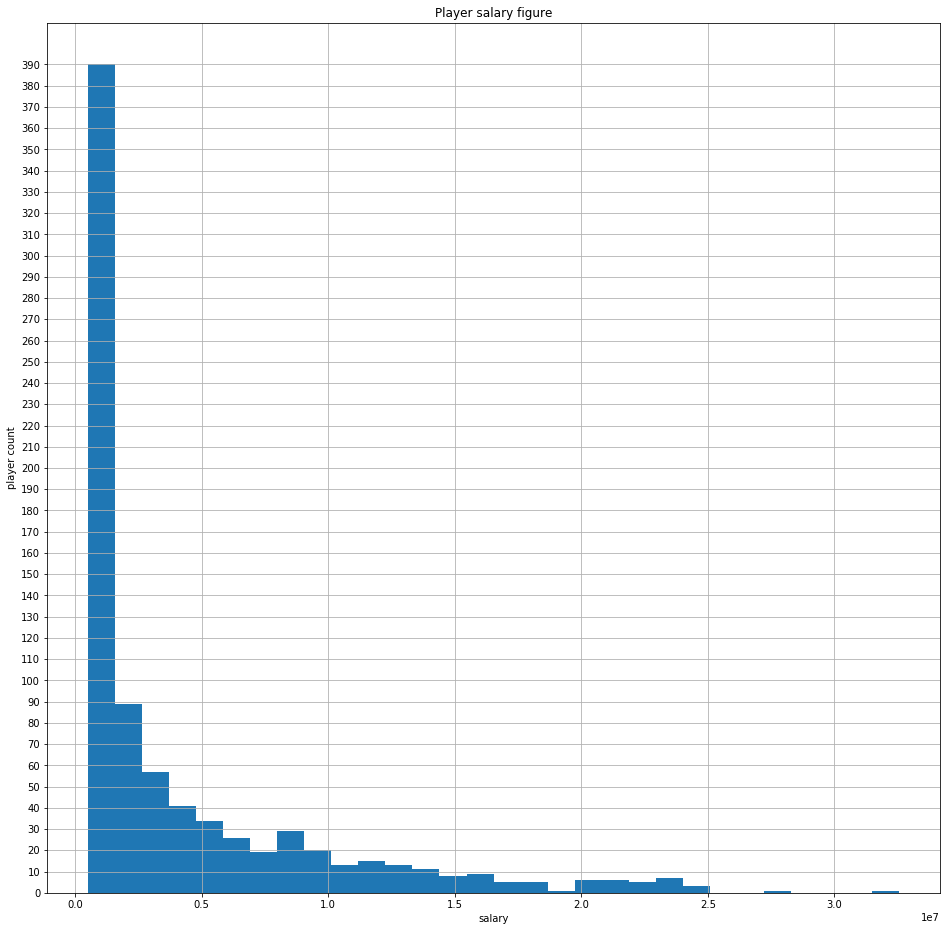

In [27]:
ax = year_salaries_df.loc[2015].salary.hist(bins=30, figsize=(16, 16))
yticks = ax.set_yticks(range(0, 400, 10))
ax.set_title('Player salary figure')
ax.set_xlabel('salary')
ax.set_ylabel('player count')

球员薪资分布图，显示了球员薪资是一个 Positive Skew分布，薪资水平上升，优秀的球员脱颖而出。

[]

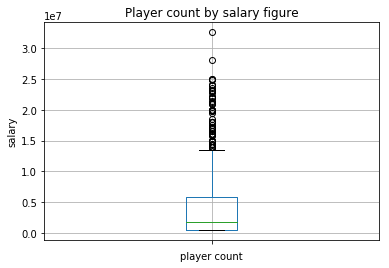

In [28]:
ax = year_salaries_df.loc[2015].salary.plot.box(grid=True)
ax.set_title('Player count by salary figure')
ax.set_ylabel('salary')
ax.set_xlabel('player count')
ax.set_xticklabels([])

和上面的图结合一起看。可以看到中位数很低，意味着众数在100万年薪的水平，这算是MLB中的蓝领阶层 ~_~

精英阶层则是在600万以上的年薪水平，超一流球员则是1500万以上年薪水平。这张图可以说明MLB球员薪资差距很大

显示某个赛季中球员BMI和薪资的相关性

通过数据显示一下MLB球员的高薪球员是否代表身体素质超过一般水平。

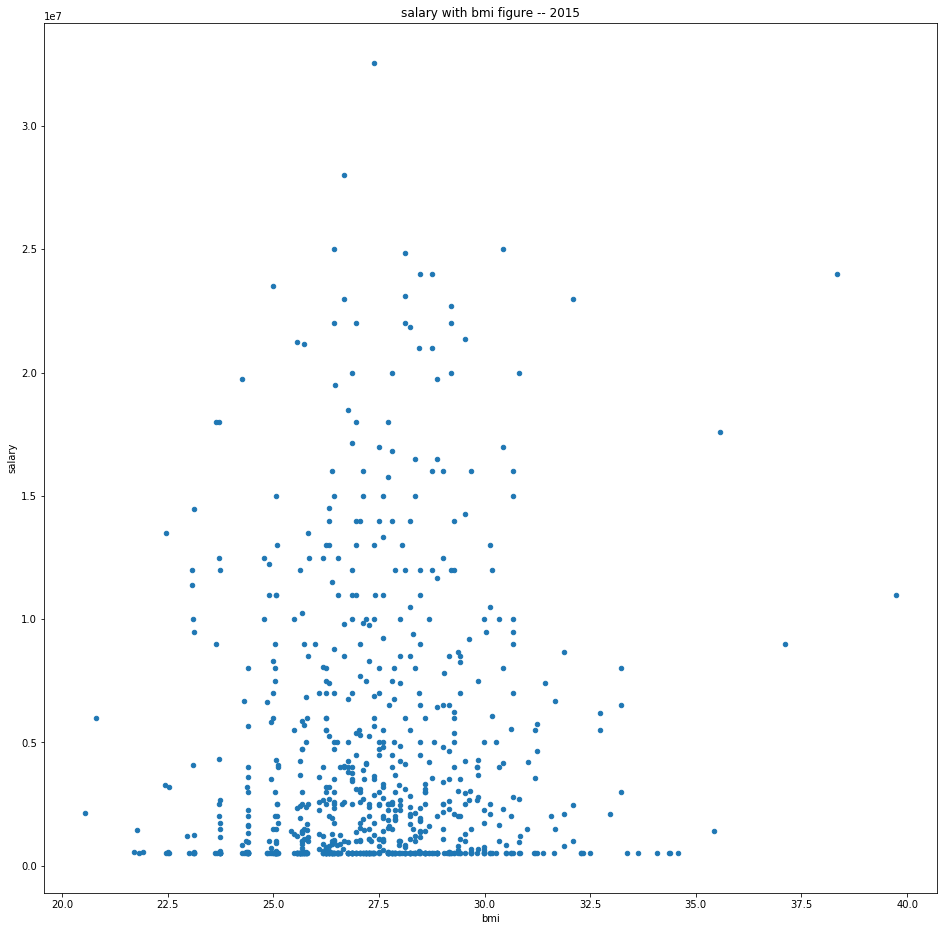

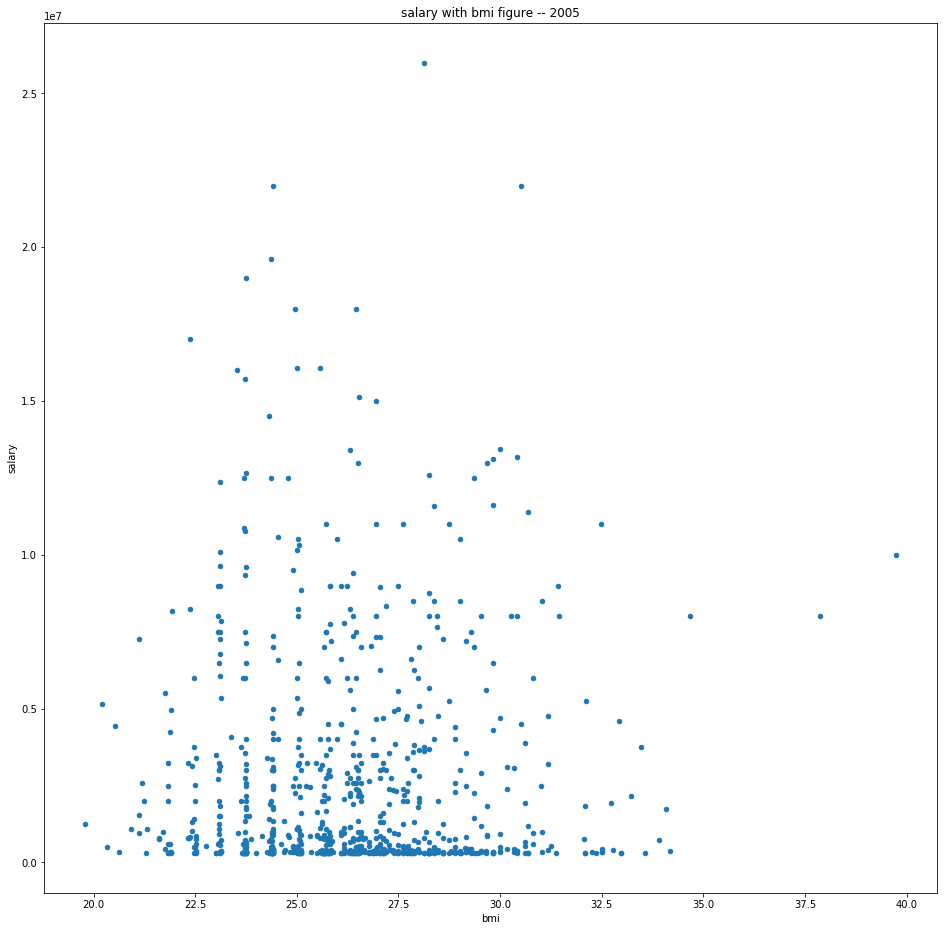

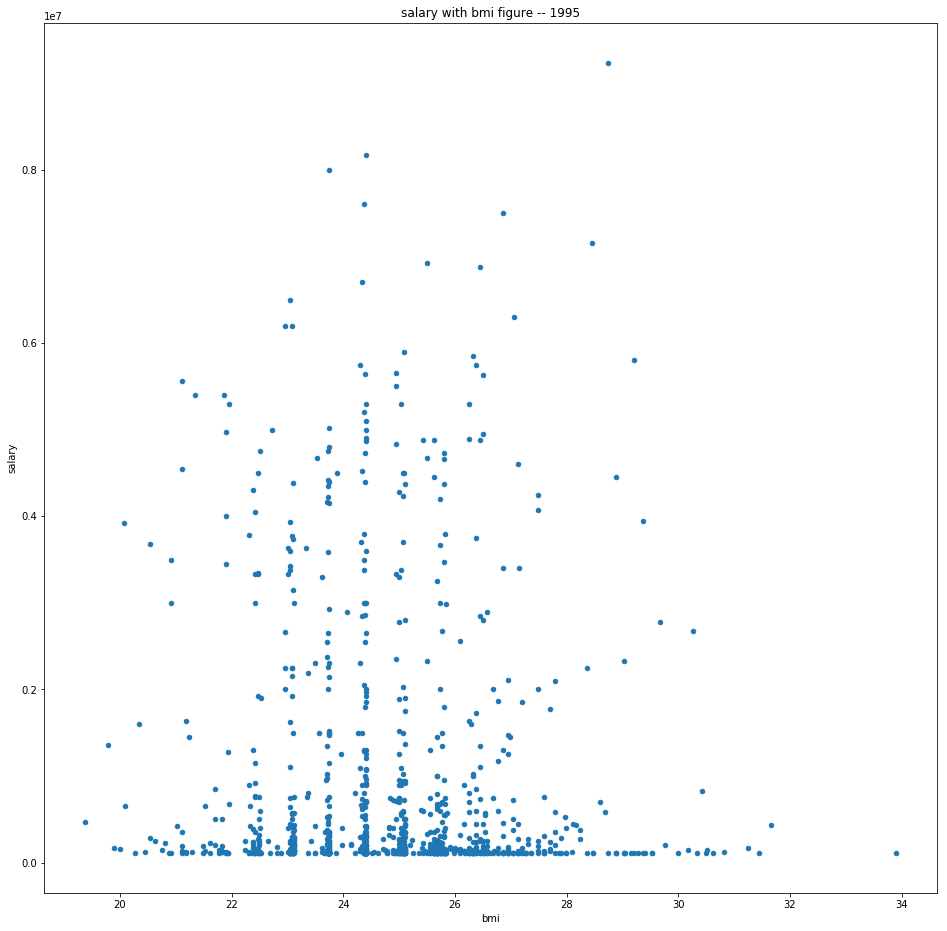

In [29]:
def bmi_with_salary_corr(year_salaries_df, yearID):
    salaries_df = year_salaries_df.loc[yearID]
    title = 'salary with bmi figure -- ' + str(yearID)
    ax = salaries_df[['bmi', 'salary']].plot.scatter(figsize=(16, 16), x='bmi', y='salary')
    ax.set_title(title)
    
bmi_with_salary_corr(year_salaries_df, 2015)
bmi_with_salary_corr(year_salaries_df, 2005)
bmi_with_salary_corr(year_salaries_df, 1995)

图形可以看到MLB球员的薪资水平（也可看作棒球能力水平）不完全取决于肌肉水平，有部分BMI严重超标的球员的薪资水平仍然处于中上游。

从侧面说明MLB不算是高强度对抗性的运动（待调查...）

按赛季高薪球员的数量，分别统计1000万和2000万以上薪资的数量

In [30]:
def salary_club_greater_than(year_salaries_df, yearID, salary):
    df1 = year_salaries_df.loc[yearID]
    df2 = df1.salary.loc[lambda s: s >= salary]
    return df2.shape[0]

def salary_club_greater_than_10m(year_salaries_df, yearID):
    return salary_club_greater_than(year_salaries_df, yearID, 10000000)

def salary_club_greater_than_20m(year_salaries_df, yearID):
    return salary_club_greater_than(year_salaries_df, yearID, 20000000)


In [31]:
print '10M, 2015:', salary_club_greater_than_10m(year_salaries_df, 2015)
print '20M, 2015:', salary_club_greater_than_20m(year_salaries_df, 2015)
print '10M, 2010:', salary_club_greater_than_10m(year_salaries_df, 2010)
print '20M, 2010:', salary_club_greater_than_20m(year_salaries_df, 2010)

10M, 2015: 120
20M, 2015: 27
10M, 2010: 82
20M, 2010: 6


按赛季统计球员年龄和薪资的关系

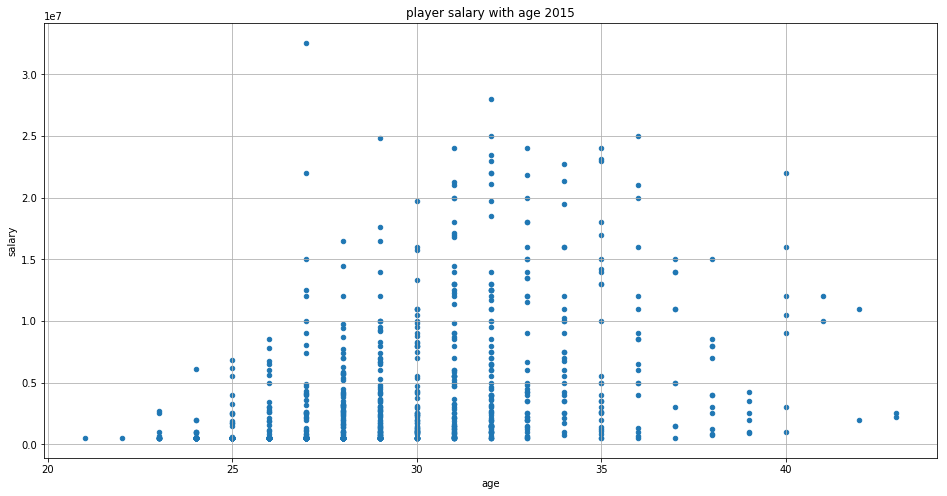

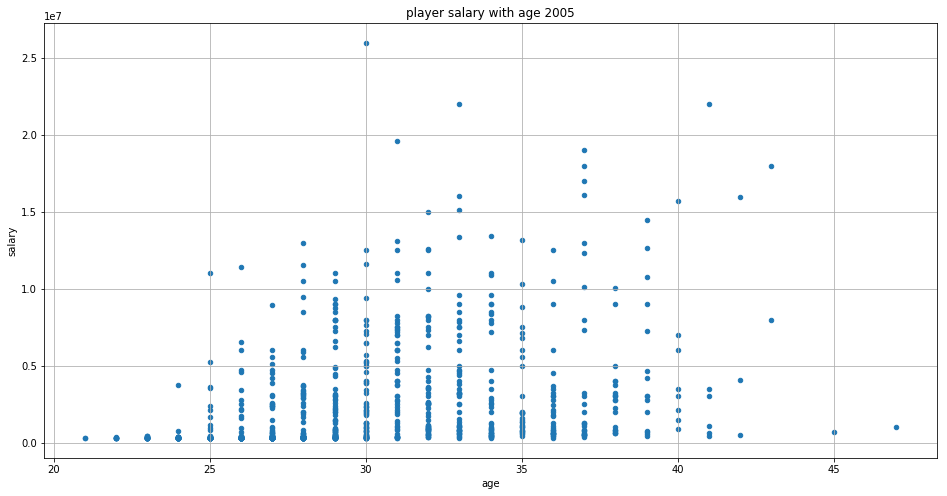

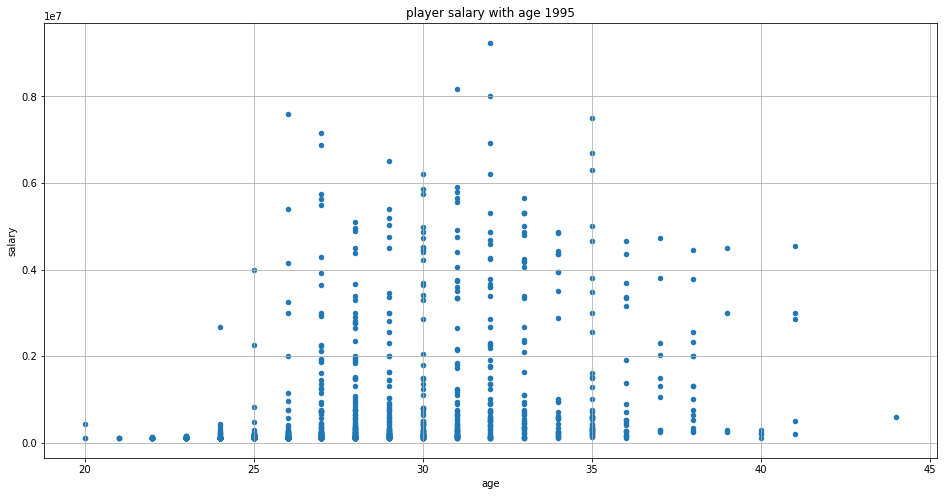

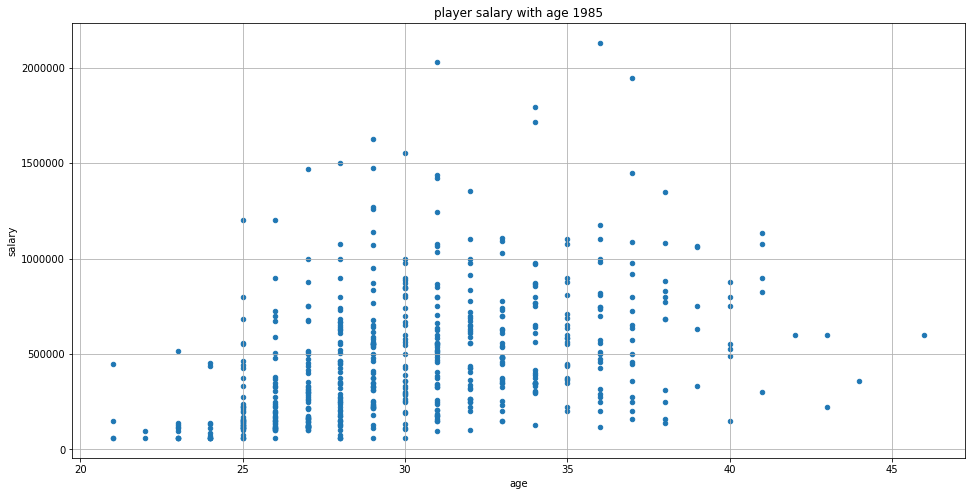

In [32]:

def draw_age_sal_plot(df, yearID):
    year_df = df.loc[yearID][['salary','age']]    
    title = 'player salary with age ' + str(yearID)
    yticks = ax.set_yticks(range(0, 400, 10))
    year_df.plot.scatter(x='age', y='salary', 
                             figsize=(16, 8), grid=True,
                        title = title)

draw_age_sal_plot(year_salaries_df, 2015)
draw_age_sal_plot(year_salaries_df, 2005)
draw_age_sal_plot(year_salaries_df, 1995)
draw_age_sal_plot(year_salaries_df, 1985)

### MLB球员的哪个年龄段是黄金年龄（拿到高薪）？

通过散点图进行观察，考虑到通货膨胀和球员薪资平均水平的增长，按赛季绘制散点图。

通过观察发现，在30-35这个区域岁之间是球员高薪比较集中的区域。可以认为是球员的黄金年龄




计算场均BATTING数据(考虑赛季中转会的因素）
* G              Games
* AB             At Bats
* R              Runs
* H              Hits
* 2B             Doubles
* 3B             Triples
* HR             Homeruns
* RBI            Runs Batted In
* SB             Stolen Bases
* CS             Caught Stealing
* BB             Base on Balls
* SO             Strikeouts
* IBB            Intentional walks
* HBP            Hit by pitch
* SH             Sacrifice hits
* SF             Sacrifice flies
* GIDP           Grounded into double plays


In [33]:
batting_df = pd.read_csv('./baseballdatabank-master/core/Batting.csv')
batting_df = batting_df[batting_df['yearID']>=START_YEAR].set_index(['playerID', 'yearID', 'teamID']).groupby(['playerID', 'yearID']).sum()
#batting_df = batting_df.set_index(['playerID', 'yearID', 'teamID'])
print batting_df

                  stint    G     AB     R      H    2B   3B    HR   RBI   SB  \
playerID  yearID                                                               
aardsda01 2004        1   11    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2006        1   45    2.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2007        1   25    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2008        1   47    1.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2009        1   73    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2010        1   53    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2012        1    1    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2013        1   43    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2015        1   33    1.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
aasedo01  1985        1   54    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          1986        1   66    0.0   0.

In [34]:

def gameavg_batting(row):
    result = {}
    games = row['G']
    if games == 0:
        games = 1
    result['gab_ab'] = row['AB']/games
    result['gab_h'] = row['H']/games
    result['gab_2b'] = row['2B']/games
    result['gab_3b'] = row['3B']/games
    result['gab_hr'] = row['HR']/games
    result['gab_rbi'] = row['RBI']/games
    result['gab_sb'] = row['SB']/games
    result['gab_cs'] = row['CS']/games
    result['gab_bb'] = row['3B']/games
    result['gab_so'] = row['SO']/games
    result['gab_ibb'] = row['IBB']/games
    result['gab_hbp'] = row['HBP']/games
    result['gab_sh'] = row['SH']/games
    result['gab_sf'] = row['SF']/games
    result['gab_gidp'] = row['GIDP']/games
    return pd.Series(result)
ga_batting_df = batting_df.merge(batting_df.apply(lambda row: gameavg_batting(row), axis=1),
                 left_index=True, right_index=True,
                 validate='1:1')
#batting_df[['result['gab_ab','gab_h','gab_2b','gab_3b','gab_hr','gab_rbi','gab_sb','gab_cs','gab_bb','gab_so','gab_ibb','gab_hbp','gab_sh','gab_sf','gab_gidp']]'] = batting_df.apply(lambda row: gameavg_batting(row), axis=1)
print ga_batting_df

                  stint    G     AB     R      H    2B   3B    HR   RBI   SB  \
playerID  yearID                                                               
aardsda01 2004        1   11    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2006        1   45    2.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2007        1   25    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2008        1   47    1.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2009        1   73    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2010        1   53    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2012        1    1    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2013        1   43    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2015        1   33    1.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
aasedo01  1985        1   54    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          1986        1   66    0.0   0.

计算场均投球数据(考虑赛季中转会的因素）
* W              Wins
* L              Losses
* G              Games
* GS             Games Started
* CG             Complete Games 
* SHO            Shutouts
* SV             Saves
* IPOuts         Outs Pitched (innings pitched x 3)
* H              Hits
* ER             Earned Runs
* HR             Homeruns
* BB             Walks
* SO             Strikeouts
* BAOpp          Opponent's Batting Average
* ERA            Earned Run Average
* IBB            Intentional Walks
* WP             Wild Pitches
* HBP            Batters Hit By Pitch
* BK             Balks
* BFP            Batters faced by Pitcher
* GF             Games Finished
* R              Runs Allowed
* SH             Sacrifices by opposing batters
* SF             Sacrifice flies by opposing batters
* GIDP           Grounded into double plays by opposing batter



In [35]:
pitching_df = pd.read_csv('./baseballdatabank-master/core/Pitching.csv')
pitching_df = pitching_df[pitching_df['yearID']>=START_YEAR].set_index(['playerID', 'yearID', 'teamID']).groupby(['playerID', 'yearID']).sum()
print pitching_df

                  stint   W   L   G  GS  CG  SHO  SV  IPouts    H  ...    IBB  \
playerID  yearID                                                   ...          
aardsda01 2004        1   1   0  11   0   0    0   0    32.0   20  ...    0.0   
          2006        1   3   0  45   0   0    0   0   159.0   41  ...    0.0   
          2007        1   2   1  25   0   0    0   0    97.0   39  ...    3.0   
          2008        1   4   2  47   0   0    0   0   146.0   49  ...    2.0   
          2009        1   3   6  73   0   0    0  38   214.0   49  ...    3.0   
          2010        1   0   6  53   0   0    0  31   149.0   33  ...    5.0   
          2012        1   0   0   1   0   0    0   0     3.0    1  ...    0.0   
          2013        1   2   2  43   0   0    0   0   119.0   39  ...    6.0   
          2015        1   1   1  33   0   0    0   0    92.0   25  ...    3.0   
aasedo01  1985        1  10   6  54   0   0    0  14   264.0   83  ...    7.0   
          1986        1   6 

In [36]:

def gameavg_pitching(row):
    result = {}
    games = row['G']
    if games == 0:
        games = 1
    result['gap_wins'] = row['W']
    result['gap_losses'] = row['L']
    result['gap_games'] = games
    result['gap_started'] = row['GS']
    result['gap_completed'] = row['CG']
    result['gap_sho'] = row['SHO']/games
    result['gap_sv'] = row['SV']/games
    result['gap_ipouts'] = row['IPouts']/games
    result['gap_h'] = row['H']/games
    result['gap_hr'] = row['HR']/games
    result['gap_bb'] = row['BB']/games
    result['gap_so'] = row['SO']/games
    result['gap_baopp'] = row['BAOpp']/games
    result['gap_era'] = row['ERA']/games
    result['gap_ibb'] = row['IBB']/games
    result['gap_wp'] = row['WP']/games
    result['gap_hbp'] = row['HBP']/games
    result['gap_bk'] = row['BK']/games
    result['gap_bfp'] = row['BFP']/games
    result['gap_gf'] = row['GF']/games
    result['gap_r'] = row['R']/games
    result['gap_sh'] = row['SH']/games
    result['gap_sf'] = row['SF']/games
    result['gap_gidp'] = row['GIDP']/games
    return pd.Series(result)

ga_pitching_df = pitching_df.merge(pitching_df.apply(lambda row: gameavg_pitching(row), axis=1),
                  left_index=True, right_index=True,
                  validate='1:1')
print ga_pitching_df

                  stint   W   L   G  GS  CG  SHO  SV  IPouts    H    ...     \
playerID  yearID                                                     ...      
aardsda01 2004        1   1   0  11   0   0    0   0    32.0   20    ...      
          2006        1   3   0  45   0   0    0   0   159.0   41    ...      
          2007        1   2   1  25   0   0    0   0    97.0   39    ...      
          2008        1   4   2  47   0   0    0   0   146.0   49    ...      
          2009        1   3   6  73   0   0    0  38   214.0   49    ...      
          2010        1   0   6  53   0   0    0  31   149.0   33    ...      
          2012        1   0   0   1   0   0    0   0     3.0    1    ...      
          2013        1   2   2  43   0   0    0   0   119.0   39    ...      
          2015        1   1   1  33   0   0    0   0    92.0   25    ...      
aasedo01  1985        1  10   6  54   0   0    0  14   264.0   83    ...      
          1986        1   6   7  66   0   0    0  34

 读取 fielding 数据(考虑赛季中转会的因素）
 
 * Pos            Position
 * G              Games 
 * GS             Games Started
 * InnOuts        Time played in the field expressed as outs 
 * PO             Putouts
 * A              Assists
 * E              Errors
 * DP             Double Plays
 * PB             Passed Balls (by catchers)
 * WP             Wild Pitches (by catchers)
 * SB             Opponent Stolen Bases (by catchers)
 * CS             Opponents Caught Stealing (by catchers)
 * ZR             Zone Rating

In [37]:
fielding_df_orig = pd.read_csv('./baseballdatabank-master/core/Fielding.csv')
fielding_df = fielding_df_orig[fielding_df_orig['yearID']>=START_YEAR].set_index(['playerID', 'yearID', 'teamID']).groupby(['playerID', 'yearID']).sum()
print fielding_df

                  stint    G     GS  InnOuts      PO      A     E    DP   PB  \
playerID  yearID                                                               
aardsda01 2004        1   11    0.0     33.0     0.0    0.0   0.0   0.0  0.0   
          2006        1   45    0.0    159.0     1.0    5.0   0.0   1.0  0.0   
          2007        1   25    0.0     96.0     2.0    4.0   1.0   0.0  0.0   
          2008        1   47    0.0    147.0     3.0    6.0   0.0   0.0  0.0   
          2009        1   73    0.0    213.0     2.0    5.0   0.0   1.0  0.0   
          2010        1   53    0.0    150.0     2.0    3.0   1.0   0.0  0.0   
          2012        1    1    0.0      3.0     0.0    0.0   0.0   0.0  0.0   
          2013        1   43    0.0    120.0     1.0    5.0   0.0   0.0  0.0   
          2015        1   33    0.0      0.0     0.0    1.0   1.0   0.0  0.0   
aasedo01  1985        1   54    0.0    264.0     8.0   10.0   0.0   0.0  0.0   
          1986        1   66    0.0    2

In [38]:
def gameavg_fielding(row):
    result = {}
    games = row['G']
    if games == 0:
        games = 1
    #result['gap_pos'] = row['POS']
    result['gaf_games'] = games
    result['gaf_started'] = row['GS']
    result['gaf_innouts'] = row['InnOuts']/games
    result['gaf_po'] = row['PO']/games
    result['gaf_a'] = row['A']/games
    result['gaf_e'] = row['E']/games
    result['gaf_dp'] = row['DP']/games
    result['gaf_pb'] = row['PB']/games
    result['gaf_wp'] = row['WP']/games
    result['gaf_sb'] = row['SB']/games
    result['gaf_cs'] = row['CS']/games
    result['gaf_zr'] = row['ZR']/games
    return pd.Series(result)

ga_fielding_df = fielding_df.merge(fielding_df.apply(lambda row: gameavg_fielding(row), axis=1),
                  left_index=True, right_index=True,
                  validate='1:1')

print ga_fielding_df

                  stint    G     GS  InnOuts      PO      A     E    DP   PB  \
playerID  yearID                                                               
aardsda01 2004        1   11    0.0     33.0     0.0    0.0   0.0   0.0  0.0   
          2006        1   45    0.0    159.0     1.0    5.0   0.0   1.0  0.0   
          2007        1   25    0.0     96.0     2.0    4.0   1.0   0.0  0.0   
          2008        1   47    0.0    147.0     3.0    6.0   0.0   0.0  0.0   
          2009        1   73    0.0    213.0     2.0    5.0   0.0   1.0  0.0   
          2010        1   53    0.0    150.0     2.0    3.0   1.0   0.0  0.0   
          2012        1    1    0.0      3.0     0.0    0.0   0.0   0.0  0.0   
          2013        1   43    0.0    120.0     1.0    5.0   0.0   0.0  0.0   
          2015        1   33    0.0      0.0     0.0    1.0   1.0   0.0  0.0   
aasedo01  1985        1   54    0.0    264.0     8.0   10.0   0.0   0.0  0.0   
          1986        1   66    0.0    2

下面这段代码没有得出清晰的分析结论，先注释掉

计算球员出场数据
Appearances table:

  * `G_all` int(11) DEFAULT NULL,
  * `GS` varchar(255) DEFAULT NULL,
  * `G_batting` int(11) DEFAULT NULL,
  * `G_defense` int(11) DEFAULT NULL,
  * `G_p` int(11) DEFAULT NULL,
  * `G_c` int(11) DEFAULT NULL,
  * `G_1b` int(11) DEFAULT NULL,
  * `G_2b` int(11) DEFAULT NULL,
  * `G_3b` int(11) DEFAULT NULL,
  * `G_ss` int(11) DEFAULT NULL,
  * `G_lf` int(11) DEFAULT NULL,
  * `G_cf` int(11) DEFAULT NULL,
  * `G_rf` int(11) DEFAULT NULL,
  * `G_of` int(11) DEFAULT NULL,
  * `G_dh` varchar(255) DEFAULT NULL,
  * `G_ph` varchar(255) DEFAULT NULL,
  * `G_pr` varchar(255) DEFAULT NULL


In [39]:
# appearances_df = pd.read_csv('./baseballdatabank-master/core/Appearances.csv').set_index(['yearID'])
# salary_club = 10000000
# def draw_appearances_sal_plot(appear_df, year_salaries_df, yearID):
#     df = appear_df.loc[yearID].groupby('playerID').sum()
#     # show player games count as postition. because position is column, 
#     #   so we use dataframe.stack method convert it to row value
#     draw_df = df.stack()
#     draw_df = draw_df.reset_index().rename(columns={'level_1':'type', 0:'value'}).set_index('playerID')
#     type_defines = ['G_all', 'GS', 'G_batting', 'G_defense', 'G_p', 'G_c', 'G_1b', 'G_2b', 'G_3b', 'G_ss', 
#                         'G_lf', 'G_cf', 'G_rf', 'G_of', 'G_dh', 'G_ph', 'G_pr']
#     def convert_type_to_int(row):
#         result = {}
        
#         result['type_int'] = type_defines.index(row['type'])
#         return pd.Series(result)
#     draw_df['type_int'] = draw_df.apply(lambda row: convert_type_to_int(row), axis=1)
#     # get salary of player, we filter data by yearID at above code already.
#     salaries_df = year_salaries_df.loc[yearID].set_index('playerID')[['salary']]
#     # divide top 30 players and other players
#     top = 30
#     top_salaries_df = salaries_df.nlargest(top, 'salary')
#     other_salaries_df = salaries_df.nsmallest(len(salaries_df.index)-top, 'salary')
#     #draw top 30 players game appearances at every positions
#     draw_df_1 = draw_df.join(top_salaries_df, how='right').reset_index()
#     ax1 = draw_df_1.plot.scatter(x='type_int', y='value', s=draw_df_1.salary/100000,
#                    figsize=(16, 32), grid=True, color='DarkBlue',
#                    title = 'player appearances '+str(yearID))
#     # draw player name
#     for i, row in draw_df_1.iterrows():
#         ax1.text(row['type_int']+1, row['value'], row['playerID'])
    
#     #draw other players game appearances at every positions
#     draw_df_2 = draw_df.join(other_salaries_df, how='right').reset_index()
#     ax2 = draw_df_2.plot.scatter(x='type_int', y='value', s=draw_df_2.salary/100000, ax=ax1,
#                    figsize=(16, 32), grid=True, alpha=0.5, color='LightGreen',
#                    title = 'player appearances '+str(yearID))
#     ax2.set_xticks(range(0, len(type_defines)))
#     ax2.set_xticklabels(type_defines)

    
#draw_appearances_sal_plot(appearances_df, year_salaries_df, 2015)

In [40]:
#draw_appearances_sal_plot(appearances_df, year_salaries_df, 2010)

绘制场均 batting / salary 的相关图形（*上个版本绘制的散点图不太合理，用subplot重新绘制场均指标的散点图*)

* result['gab_ab'] = row['AB']/games
* result['gab_h'] = row['H']/games
* result['gab_2b'] = row['2B']/games
* result['gab_3b'] = row['3B']/games
* result['gab_hr'] = row['HR']/games
* result['gab_rbi'] = row['RBI']/games
* result['gab_sb'] = row['SB']/games
* result['gab_cs'] = row['CS']/games
* result['gab_bb'] = row['3B']/games
* result['gab_so'] = row['SO']/games
* result['gab_ibb'] = row['IBB']/games
* result['gab_hbp'] = row['HBP']/games
* result['gab_sh'] = row['SH']/games
* result['gab_sf'] = row['SF']/games
* result['gab_gidp'] = row['GIDP']/games

下面函数的作用是从dataframe中找到所有的场均统计的列

In [41]:

def find_ga_cols(df):
    import re
    result = []
    for col in df.columns:
        if re.match('ga\w_.*', col):
            result.append(col)
    return result        

绘制出年薪处于头部的球员和其他球员的散点图。

*采用boxplot分析就可以了，下面的代码注释掉*

In [42]:

    
# def draw_gameavg_sal_plot_impl(gameavg_df, year_salaries_df, yearID, title, gameavg_df_cols):
#     cols = gameavg_df_cols
#     df = gameavg_df.swaplevel().loc[yearID][cols]
#     print df
#     draw_df = df.stack()
#     draw_df = draw_df.reset_index().rename(columns={'level_1':'type', 0:'value'}).set_index('playerID')
#     type_defines = cols
#     def convert_type_to_int(row):
#         result = {}    
#         result['type_int'] = type_defines.index(row['type'])
#         return pd.Series(result)
#     draw_df['type_int'] = draw_df.apply(lambda row: convert_type_to_int(row), axis=1)
#     salaries_df = year_salaries_df.loc[yearID].set_index('playerID')[['salary']]
#     top = 30
#     top_salaries_df = salaries_df.nlargest(top, 'salary')
#     other_salaries_df = salaries_df.nsmallest(len(salaries_df.index)-top, 'salary')
#     draw_df_1 = draw_df.join(top_salaries_df, how='inner').reset_index()
#     print draw_df_1
#     ax1 = draw_df_1.plot.scatter(x='type_int', y='value', s=draw_df_1.salary/100000,
#                    figsize=(16, 32), grid=True, color='DarkBlue',
#                    title = 'player game a '+str(yearID))
#     for i, row in draw_df_1.iterrows():
#         ax1.text(row['type_int']+0.2, row['value'], row['playerID'])
#     #ax1.set_xticks(range(0, len(type_defines)))
#     #ax1.set_xticklabels(type_defines)
#     draw_df_2 = draw_df.join(other_salaries_df, how='inner').reset_index()
#     ax2 = draw_df_2.plot.scatter(x='type_int', y='value', s=draw_df_2.salary/100000, ax=ax1,
#                    figsize=(16, 32), grid=True, alpha=0.5, color='LightGreen',
#                    title = title + ' '+ str(yearID))
#     ax2.set_xticks(range(0, len(type_defines)))
#     ax2.set_xticklabels(type_defines)
    

# def draw_gameavg_sal_plot(gameavg_df, year_salaries_df, yearID, title):
#     max_cols = 16
#     cols = find_ga_cols(gameavg_df)
#     if len(cols) <= max_cols:
#         draw_gameavg_sal_plot_impl(gameavg_df, year_salaries_df, yearID, title, cols)
#         return
    
#     index = 1
#     slice_num = int(round(len(cols)/float(max_cols)))
#     slice_unit = len(cols)/slice_num
#     slice_rem = len(cols)%slice_num
#     start = end = 0
#     while index < slice_num+1:
#         size = slice_unit
#         if slice_rem > 0:
#             size += 1
#             slice_rem -= 1
#         end = start + size
#         draw_gameavg_sal_plot_impl(gameavg_df, year_salaries_df, yearID, title+'-'+str(index), cols[start:end])
#         start = end
#         index += 1
    
    
    


In [43]:
# draw_gameavg_sal_plot(ga_batting_df, year_salaries_df, 2015, 'player batting')

In [44]:
# draw_gameavg_sal_plot(ga_batting_df, year_salaries_df, 2010, 'player batting')

In [45]:
# draw_gameavg_sal_plot(ga_pitching_df, year_salaries_df, 2015, 'player pitching')

In [46]:
# draw_gameavg_sal_plot(ga_pitching_df, year_salaries_df, 2010, 'player pitching')

显示球员统计的每项的boxplot图，并对比顶薪球员和其他球员的图形

In [47]:

def gameavg_subplot_impl(salary_top, gameavg_df, year_salaries_df, yearID, gameavg_col, fig, inner_grid):
    '''draw subplot for one column of game average statistics.
    salary_top -- define 'N' nlargest of salary is top
    gameavg_df --  dataframe of game average statistics 
    year_salaries_df -- dataframe of player year salary statistics
    yearID -- which year data should be draw
    gameavg_col -- game average column should be draw
    fig -- figure instance
    inner_grid -- grid layout of subplots
    '''
    #make dataframe only include salary and playerID of one year. the year special by yearID
    salaries_df = year_salaries_df.loc[yearID].set_index('playerID')[['salary']]
    #divid top salary players data and other players data
    top = salary_top
    top_salaries_df = salaries_df.nlargest(top, 'salary')
    other_salaries_df = salaries_df.nsmallest(len(salaries_df.index)-top, 'salary')
    #join game average data and salary data, so we can draw a boxplot of game average column and salary
    gameavg_df = gameavg_df.loc[yearID].set_index('playerID')[[gameavg_col]]
    sample1_df = gameavg_df.join(top_salaries_df, how='inner')
    sample2_df = gameavg_df.join(other_salaries_df, how='inner')
    
    #we draw two plots, one for top players and one for others. 
    #for compare reason, we need use same y-ticks of the two plots
    max1 = sample1_df[gameavg_col].max()
    max2 = sample2_df[gameavg_col].max()
    max_yval = max1
    if max1 < max2:
        max_yval = max2
    
    #draw plots, top player use 'red' color, other player use 'blue' color
    ax = plt.Subplot(fig, inner_grid[0])
    fig.add_subplot(sample1_df[[gameavg_col]].plot.box(ax=ax, color='r', sharey=True, title=gameavg_col+' of top '+str(salary_top)))
    ax.set_ylim([0, max_yval])
    ax = plt.Subplot(fig, inner_grid[1])
    fig.add_subplot(sample2_df[[gameavg_col]].plot.box(ax=ax, color='b', sharey=True, title=gameavg_col+' of other'))
    ax.set_ylim([0, max_yval])
    return
    

def gameavg_plots(salary_top, gameavg_df, year_salaries_df, yearID, title):
    '''draw game average statistics. use grid layout so we can compare top salary players and other players.
    '''
    import matplotlib.gridspec as gridspec
    # get all game average stats columns 
    cols = find_ga_cols(gameavg_df)
    if len(cols) == 0:
        return
    # calculate grid size
    ncols = 4
    nrows = len(cols) / ncols
    if len(cols) % ncols:
        nrows += 1
    fig = plt.figure(figsize=(25, 32))
    outer = gridspec.GridSpec(nrows, ncols, wspace=0.2, hspace=0.2)
    # reindex dataframe only use 'yearID' index.
    gameavg_df = gameavg_df.reset_index().set_index('yearID')
    # draw column subplot one by one
    for idx, col in enumerate(cols):
        inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=outer[idx], wspace=0.1, hspace=0.1)
        gameavg_subplot_impl(salary_top, gameavg_df, year_salaries_df, yearID, col, fig, inner)
        
    
    

场均击球数据的对比

    再温习下各字段的含义：
* G              Games
* AB             At Bats
* R              Runs
* H              Hits
* 2B             Doubles
* 3B             Triples
* HR             Homeruns
* RBI            Runs Batted In
* SB             Stolen Bases
* CS             Caught Stealing
* BB             Base on Balls
* SO             Strikeouts
* IBB            Intentional walks
* HBP            Hit by pitch
* SH             Sacrifice hits
* SF             Sacrifice flies
* GIDP           Grounded into double plays

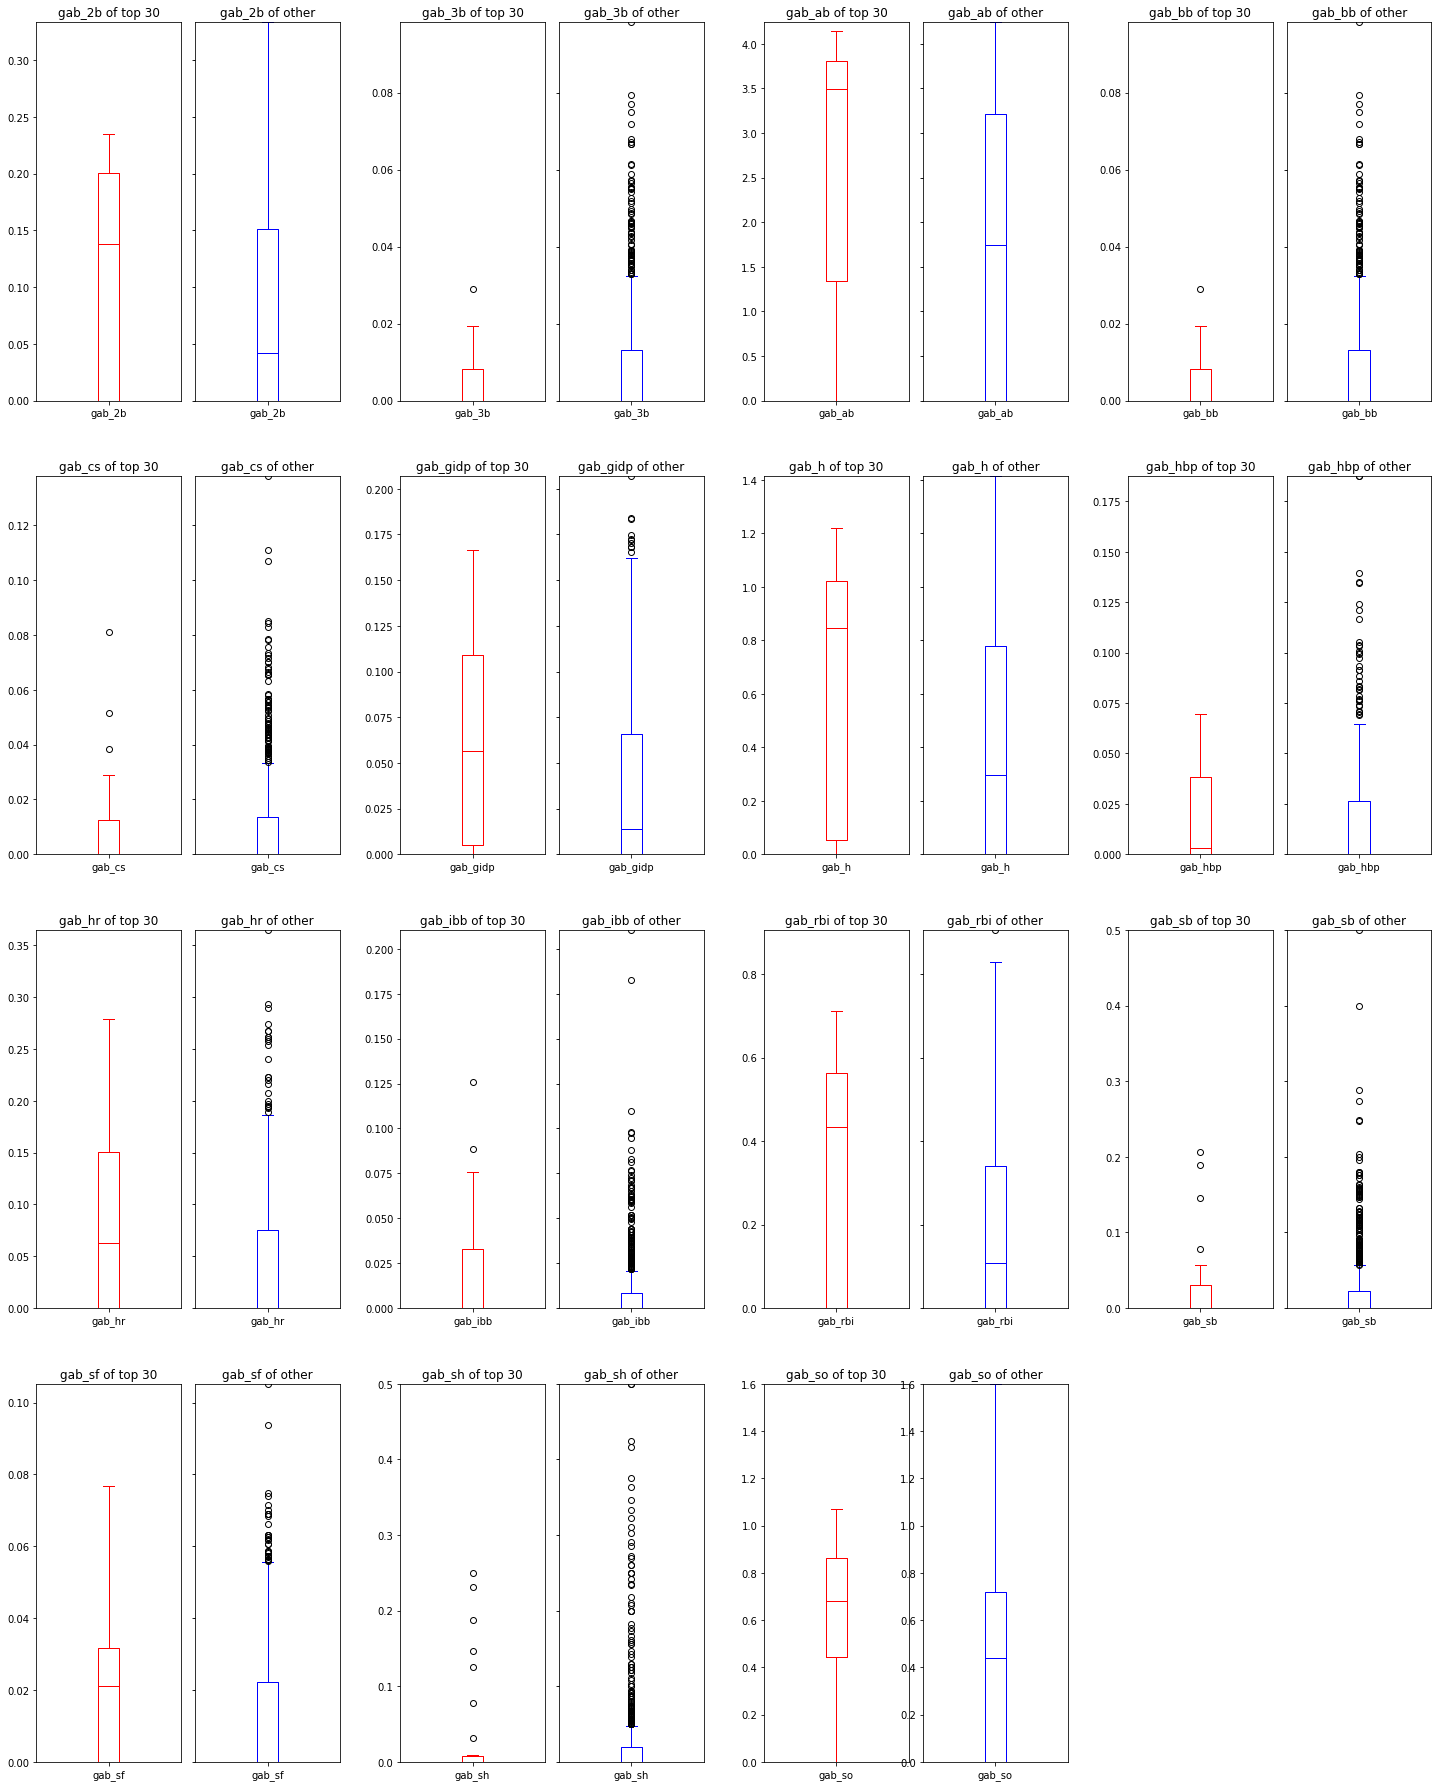

In [48]:
gameavg_plots(30, ga_batting_df, year_salaries_df, 2015, 'player batting')

从上面数据可以看到顶薪球员在负面指标上和其他球员的统计结果较接近，比如cs(盗垒失败)、bb(投手下场)。

而在考量投手的正面指标上则顶薪球员的均值都大幅领先于其他球员统计的均值。比如ab、hr(本垒打)、rbi、gidp、h(击球数）等指标。

场均投球数据的对比

    再温习下各字段的含义
* W              Wins
* L              Losses
* G              Games
* GS             Games Started
* CG             Complete Games 
* SHO            Shutouts
* SV             Saves
* IPOuts         Outs Pitched (innings pitched x 3)
* H              Hits
* ER             Earned Runs
* HR             Homeruns
* BB             Walks
* SO             Strikeouts
* BAOpp          Opponent's Batting Average
* ERA            Earned Run Average
* IBB            Intentional Walks
* WP             Wild Pitches
* HBP            Batters Hit By Pitch
* BK             Balks
* BFP            Batters faced by Pitcher
* GF             Games Finished
* R              Runs Allowed
* SH             Sacrifices by opposing batters
* SF             Sacrifice flies by opposing batters
* GIDP           Grounded into double plays by opposing batter

/opt/miniconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


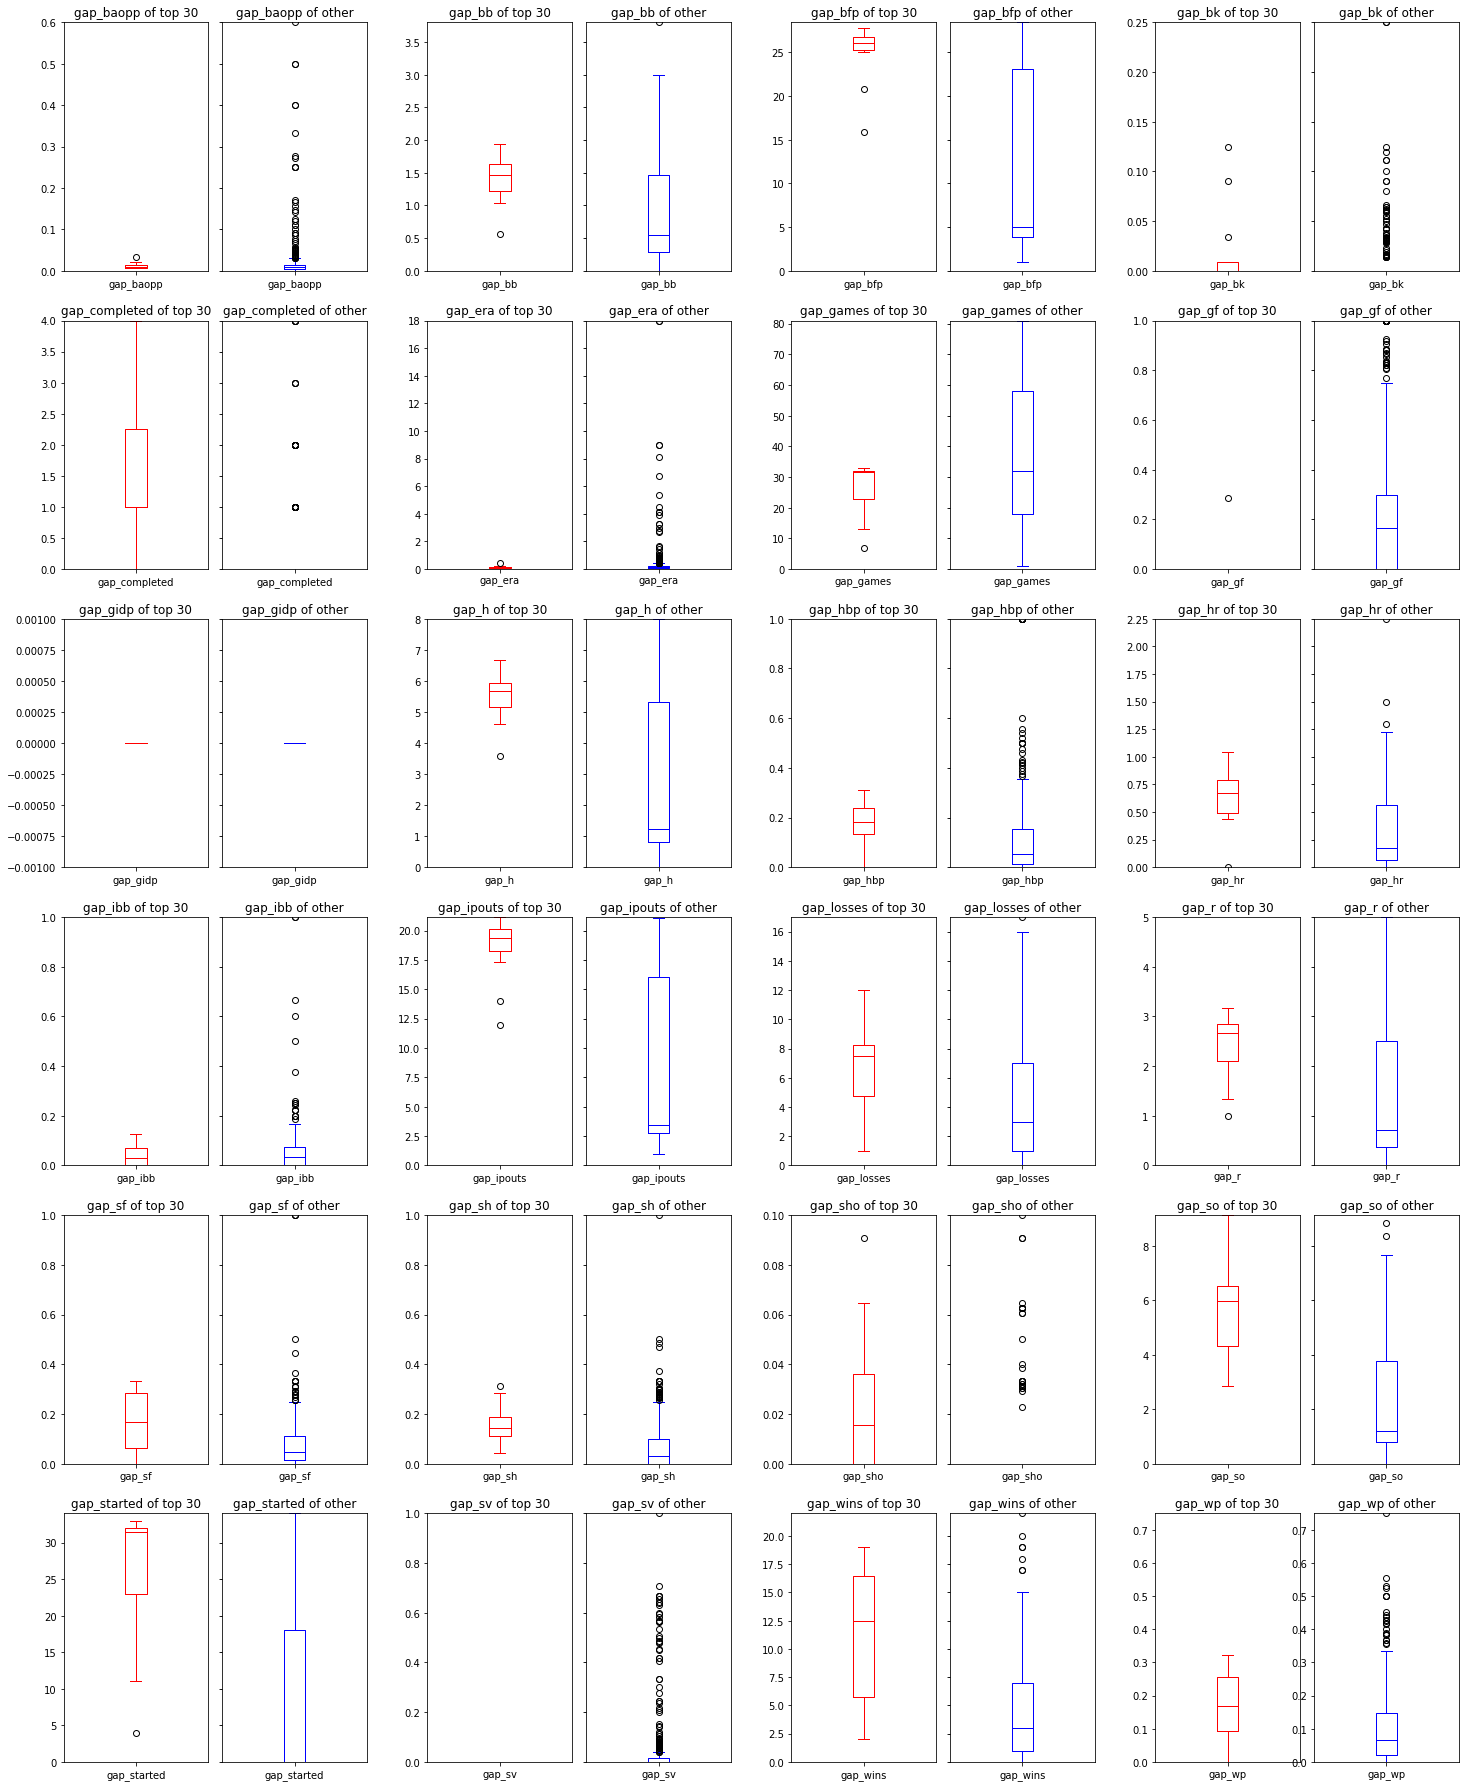

In [49]:
gameavg_plots(30, ga_pitching_df, year_salaries_df, 2015, 'player pitching')

从图形中可以看到，和击球数据不一样的是，很多表示投手失败的指标上顶薪球员要高过普通球员，比如 h(被击球)、r(投手失分)、
hr(被本垒打)、gidp(投手下场)、losses（投手败投）等。

但是看到另外一些指标比如 completed(投手完场)、started(先发)、wins(胜场）中顶薪球员也大幅领先，因此上面的负面指标高，个人理解为顶薪球员责任过大出场次数太高，导致统计的指标值也较高。

场均防守数据的对比

    再温习下各字段的含义：
 
 * Pos            Position
 * G              Games 
 * GS             Games Started
 * InnOuts        Time played in the field expressed as outs 
 * PO             Putouts
 * A              Assists
 * E              Errors
 * DP             Double Plays
 * PB             Passed Balls (by catchers)
 * WP             Wild Pitches (by catchers)
 * SB             Opponent Stolen Bases (by catchers)
 * CS             Opponents Caught Stealing (by catchers)
 * ZR             Zone Rating

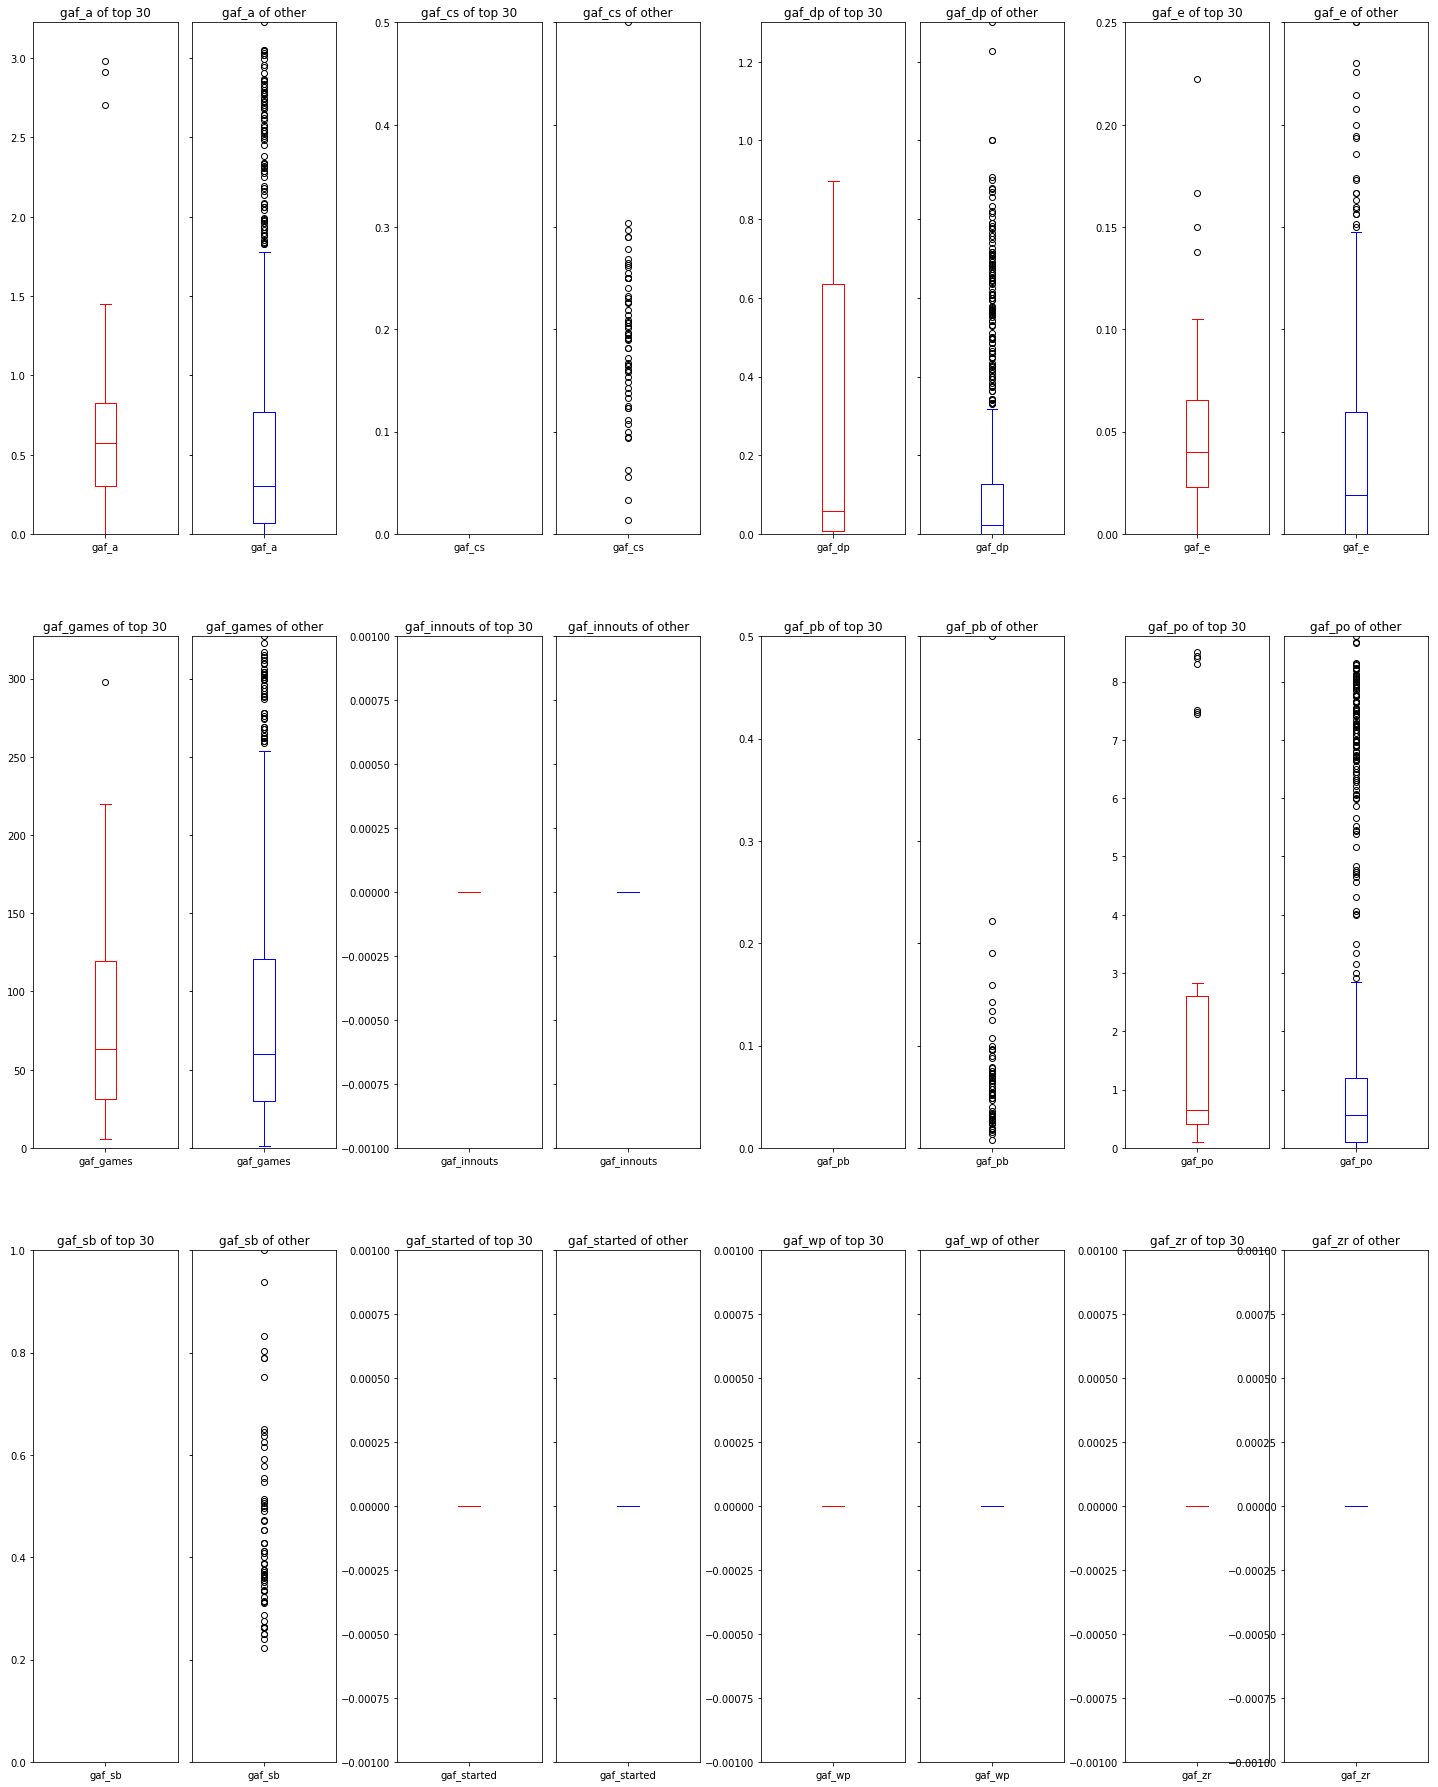

In [50]:
gameavg_plots(30, ga_fielding_df, year_salaries_df, 2015, 'player fielding')

通过观察图形发现，防守数据上顶薪球员和其他球员差距不如击球和投球那么大。这说明“防守靠努力“和”蓝领重防守“的规律在棒球领域也适用...

### 通过统计图形发现了高薪球员的主要特点是什么？

  通过上面的箱形图，对比了TOP 30球员和其他球员。TOP 30球员的图形以红色表示，其他球员以蓝色表示。

观察发现大部份指标，TOP 30球员的均值达到或者超过了其他球员的75%水平。





通过相关性分析，找出有哪些球员比赛数据指标是强相关的

In [51]:
def combine_all_gameavg_stats(gameavg_df_list, yearID):
    '''combine all game average statistics to one dataframe
    '''
    filtered_df_list = []
    for gameavg_df in gameavg_df_list:
        cols = find_ga_cols(gameavg_df)
        df = gameavg_df.swaplevel().loc[yearID][cols]
        filtered_df_list.append(df)
    df = filtered_df_list[0]
    for idx, df1 in enumerate(filtered_df_list[1:]):
        df = df.join(df1, how="inner", rsuffix=str(idx))
    return df


# plot_corr copy from stackoverflow: https://stackoverflow.com/a/31384328
def plot_corr(corr_df,title, size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr_df, interpolation='nearest')
    ax.set_title(title)
    fig.colorbar(cax)
    plt.xticks(range(len(corr_df.columns)), corr_df.columns);
    plt.yticks(range(len(corr_df.columns)), corr_df.columns);
    

def analyse_gameavg_corr(gameavg_df, yearID, title):
    '''analyse one type game average statistics
    '''
    cols = find_ga_cols(gameavg_df)
    df = gameavg_df.swaplevel().loc[yearID][cols]
    title = title + ' -- ' + str(yearID)
    plot_corr(df.corr(), title, size=25)
    
def analyse_all_gameavg_corr(gameavg_df_list, yearID, title):
    '''analyse all type gameaverage statistics
    '''
    df = combine_all_gameavg_stats(gameavg_df_list, yearID)
    corr_df = df.corr()
    title = title + ' -- ' + str(yearID) 
    plot_corr(corr_df, title, size=40)

    
def sort_all_gameavg_corr(gameavg_df_list, yearID, title):
    '''print top corr values 
    '''
    df = combine_all_gameavg_stats(gameavg_df_list, yearID)
    print title
    print get_top_abs_correlations(df, 50)
    
### The two functions copy from https://stackoverflow.com/a/41453817
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]
    
    
    


分析投球数据的相关性（*黄色是正相关，紫色是负相关，绿色的相关度较低*）

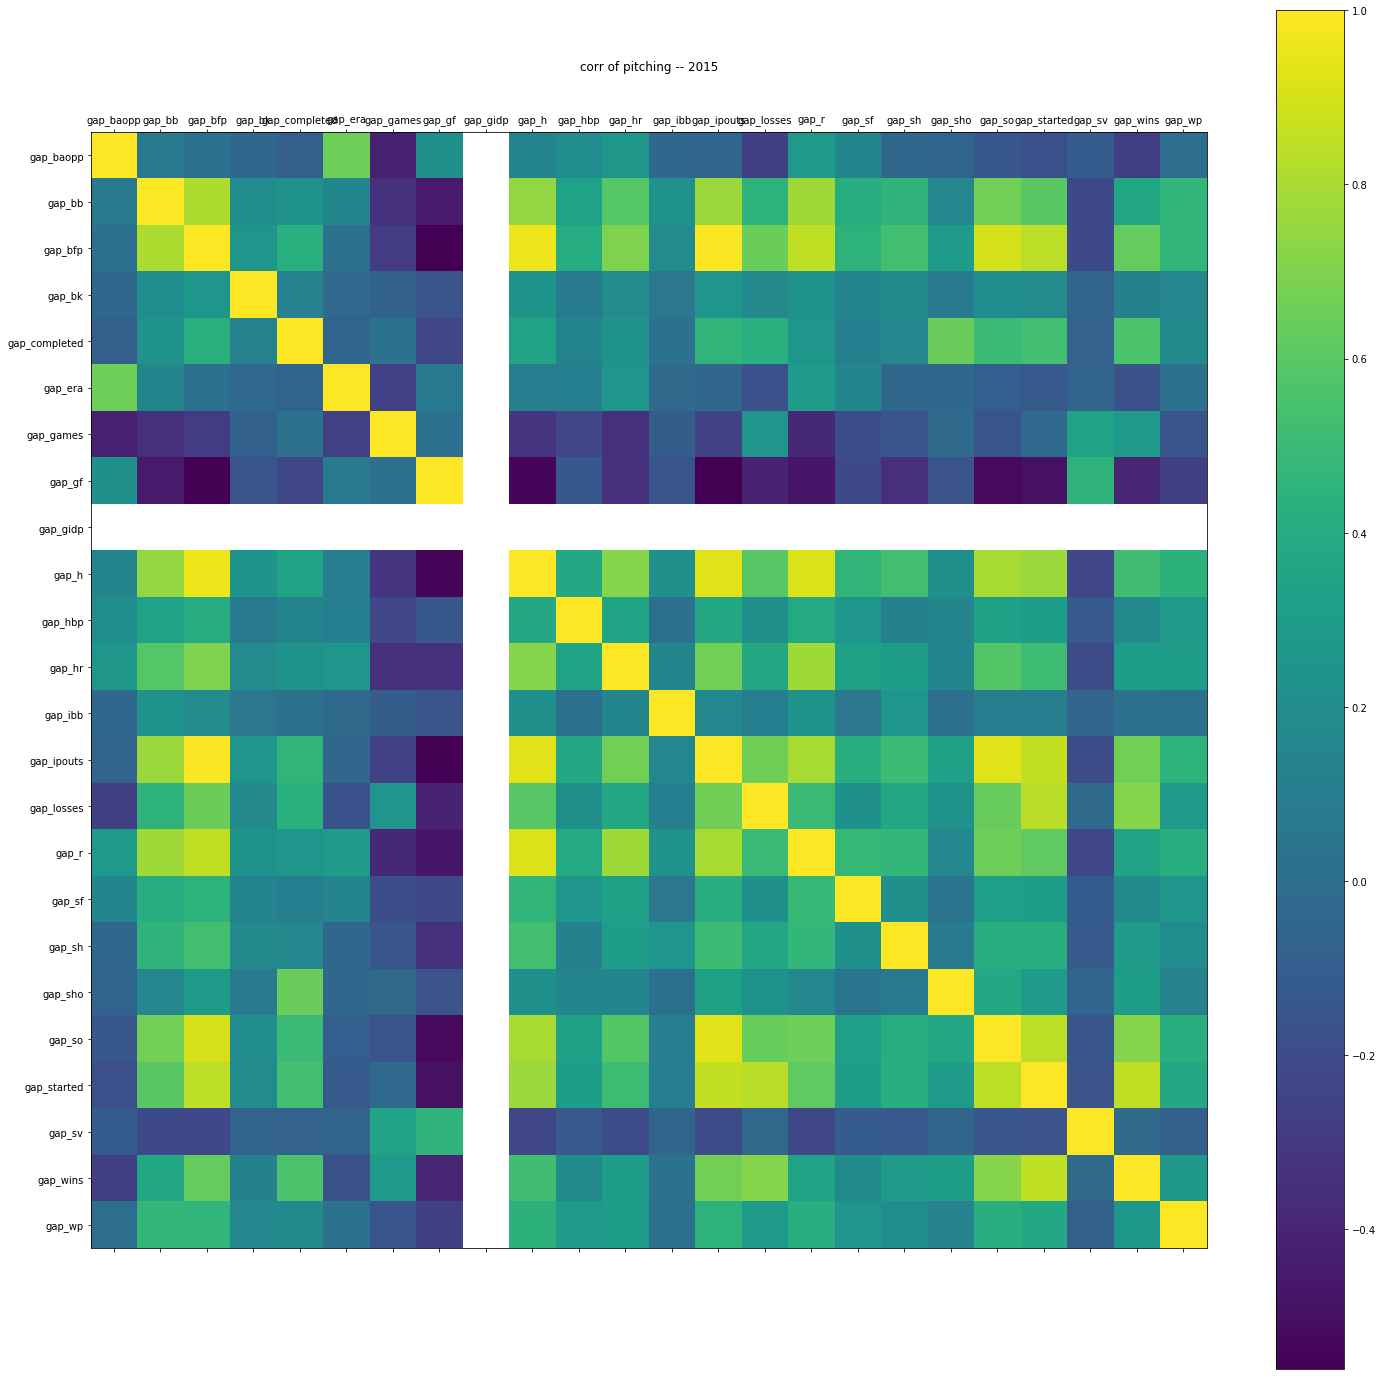

In [52]:
analyse_gameavg_corr(ga_pitching_df, 2015, 'corr of pitching')



从上面图可以看到, bfp和较多指标有正相关，gf和较多指标有负相关。

表示bfp和gf都受较多种指标影响

分析击球数据的相关性

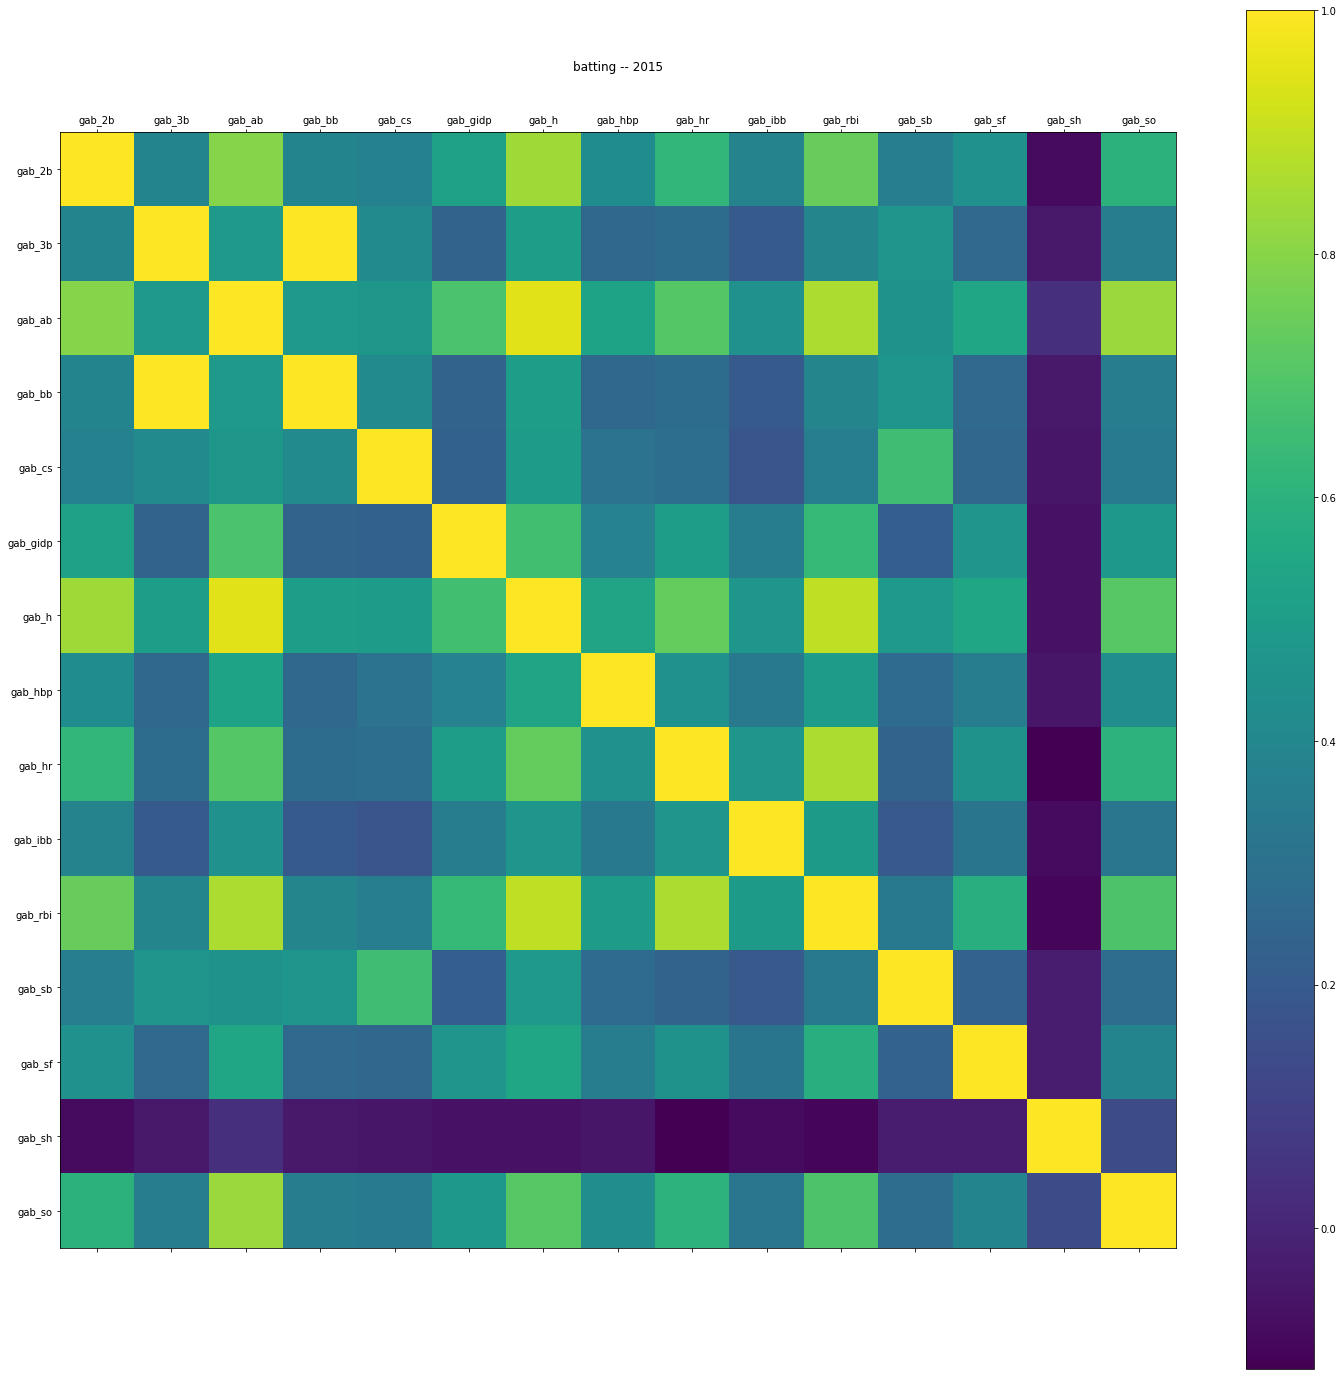

In [53]:
analyse_gameavg_corr(ga_batting_df, 2015, 'batting')

从上图可以看到，3b和bb的关联性为1，表示这两个指标是同一个。

sh和其他指标都是强烈负相关，这说明当其他指标代表的击球表现不成功时，就应当计入sh。

h 和 ab 的关联度也较高，因为h(*hits*)大部分情况下导致ab。

rbi和 ab、h、hr关联度较高。

分析防守数据的相关性

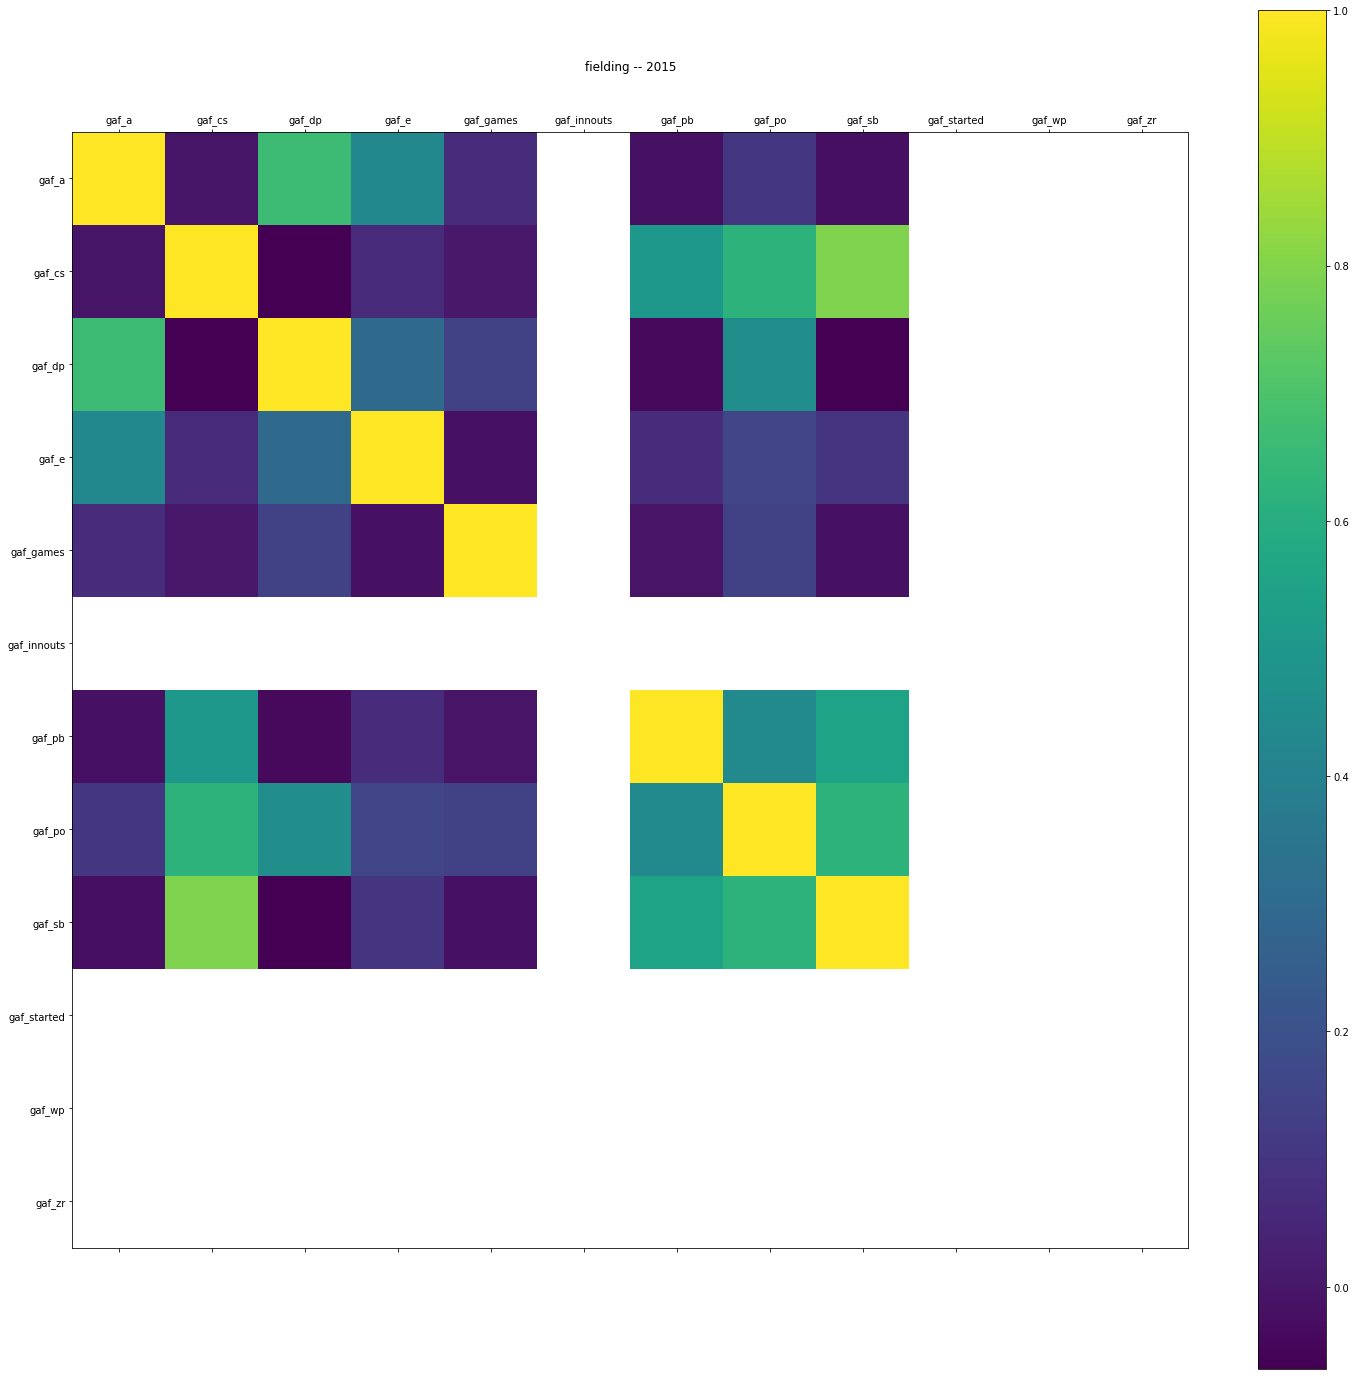

In [54]:
analyse_gameavg_corr(ga_fielding_df, 2015, 'fielding')


防守数据中的有较多负相关的指标。

因为表里记录的很多是防守失败指标，和参加的比赛数量正好负相关（*因比赛越多被统计到的失败次数就越多*）

把三种指标联合起来分析，看看不同类型的指标之间会不会有关联性

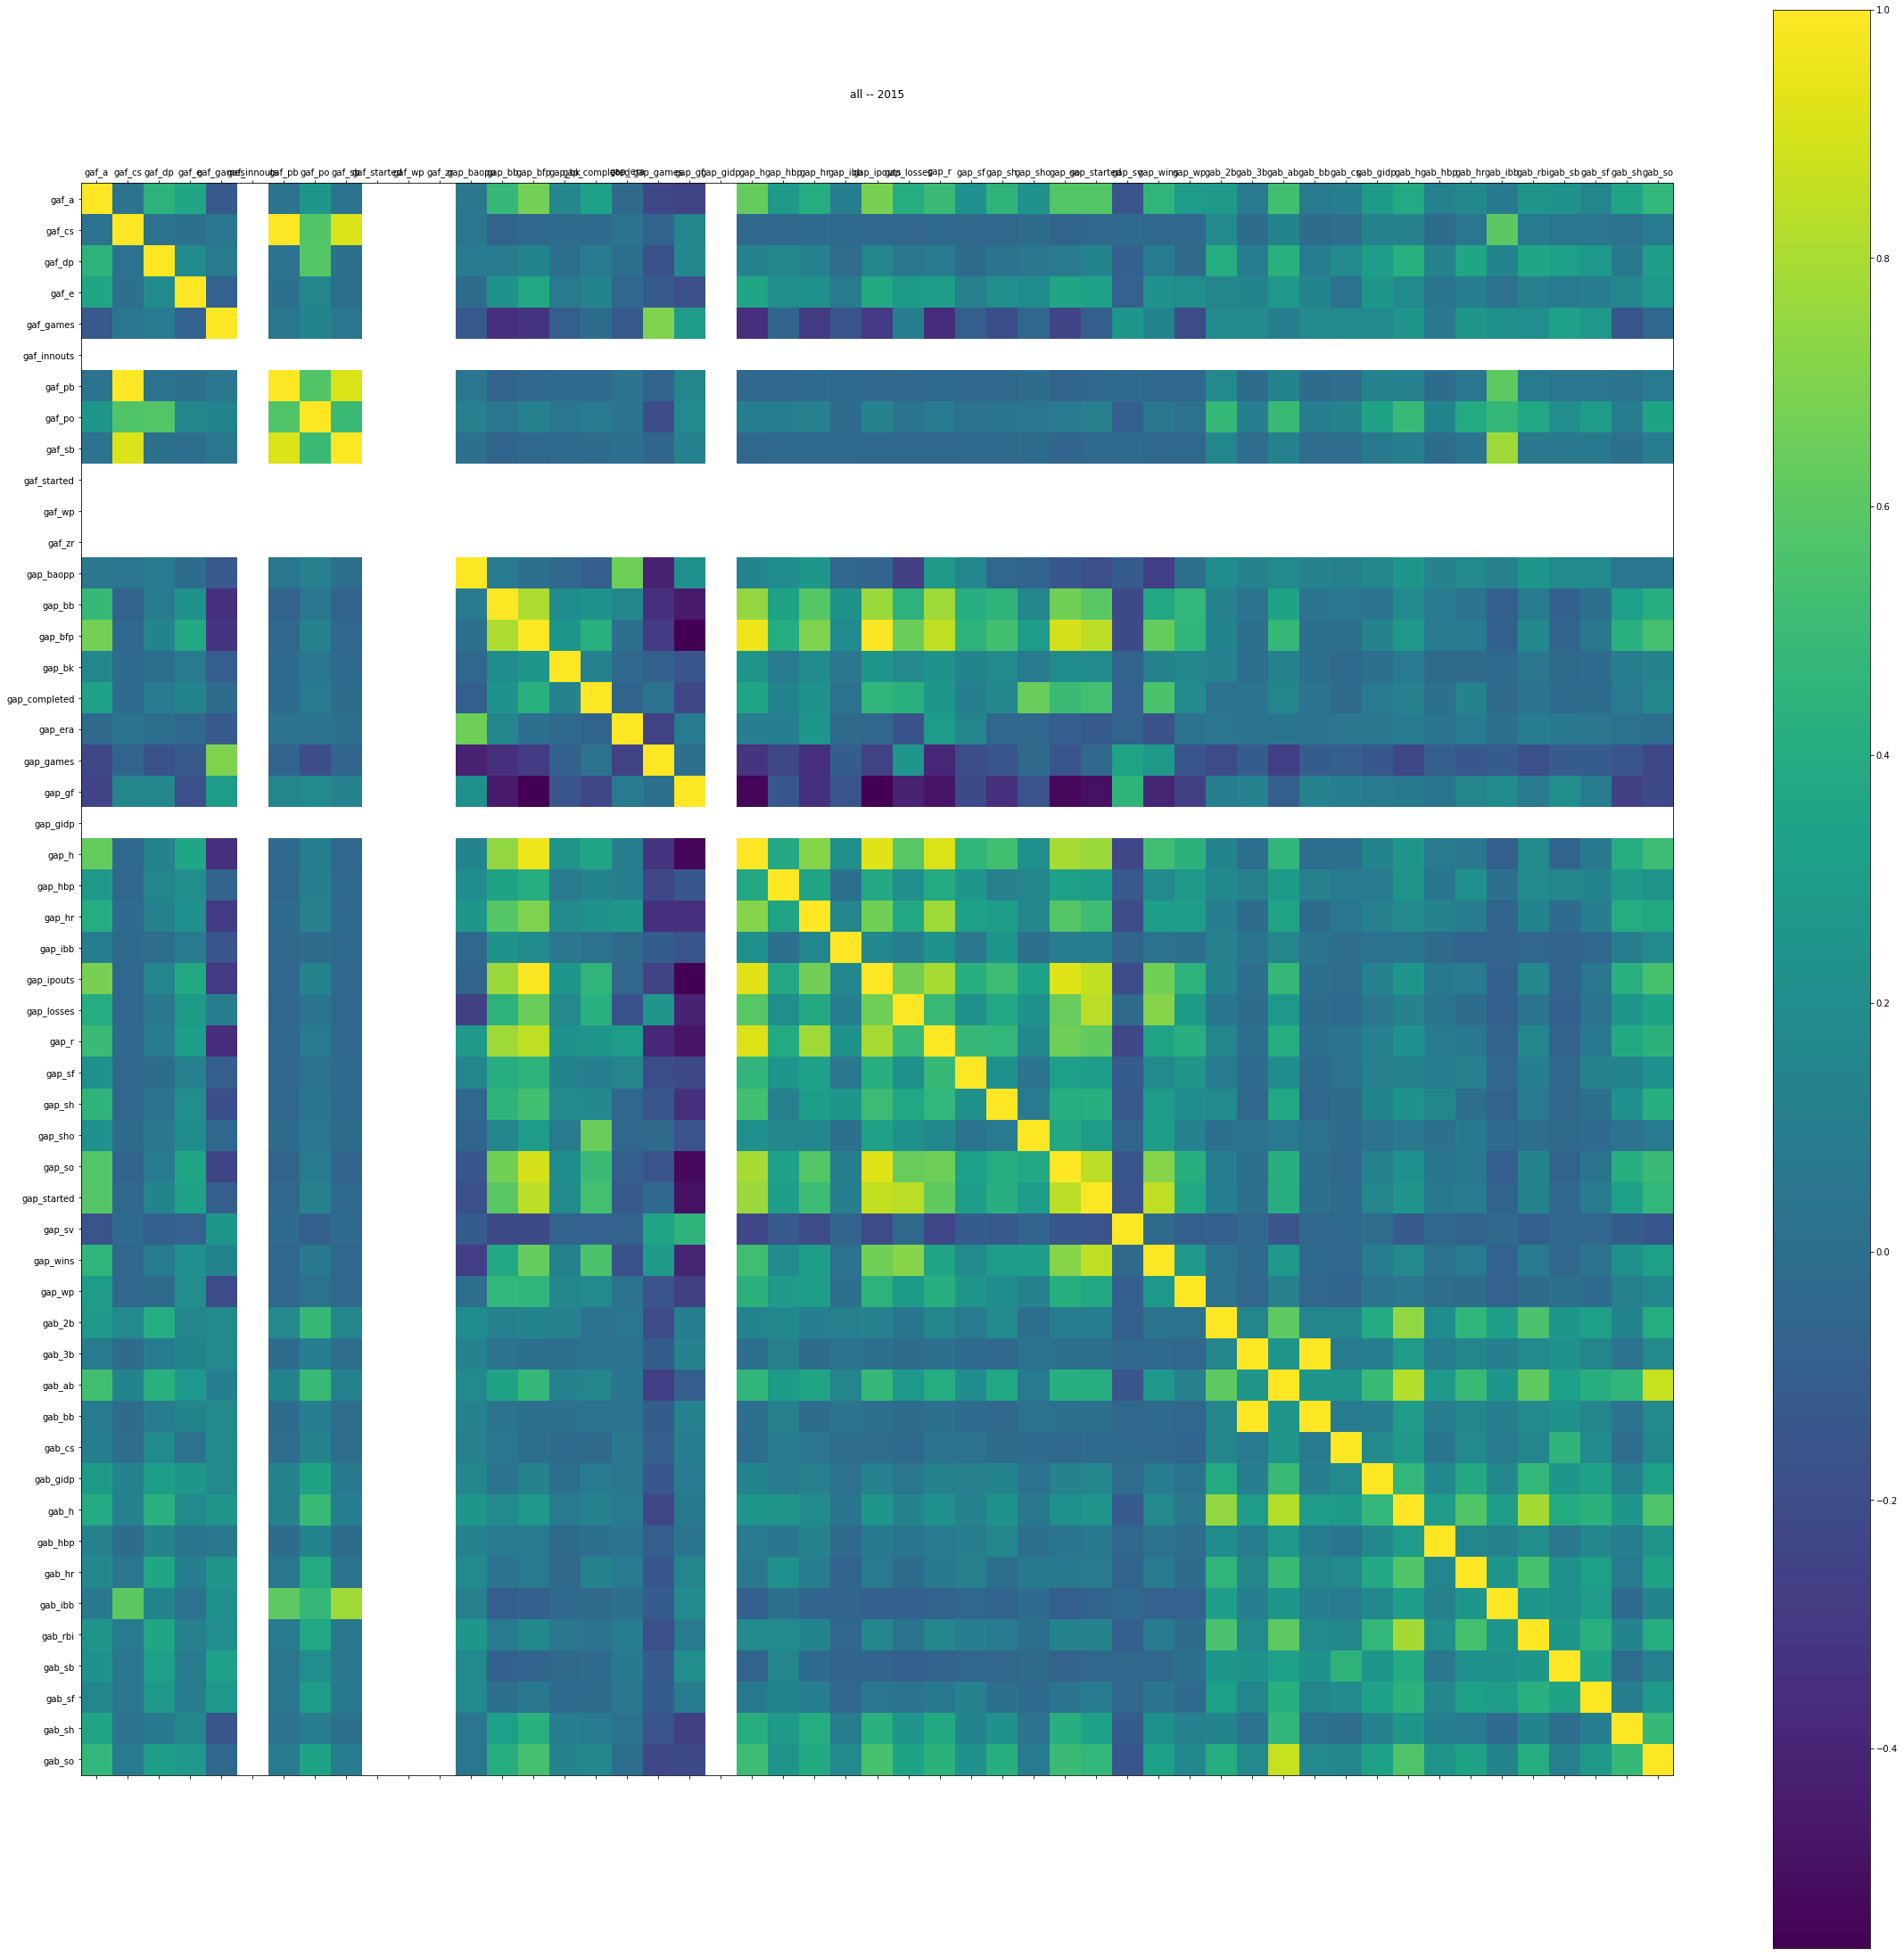

In [55]:
analyse_all_gameavg_corr([ga_fielding_df, ga_pitching_df, ga_batting_df], 2015, 'all')


可以看到不同类型的指标之间的关联很弱

打印不同类型指标的关联性的数值并进行排序看下

In [56]:
sort_all_gameavg_corr([ga_fielding_df, ga_pitching_df, ga_batting_df], 2015, 'all')

all
gab_3b         gab_bb         1.000000
gaf_cs         gaf_pb         0.999953
gap_bfp        gap_ipouts     0.993521
               gap_h          0.958638
gap_h          gap_ipouts     0.929720
gap_ipouts     gap_so         0.922082
gap_h          gap_r          0.917383
gaf_pb         gaf_sb         0.912967
gaf_cs         gaf_sb         0.908985
gap_bfp        gap_so         0.899778
gab_ab         gab_so         0.869082
gap_ipouts     gap_started    0.859466
gap_bfp        gap_r          0.851553
gap_started    gap_wins       0.849409
gap_bfp        gap_started    0.842539
gap_so         gap_started    0.842038
gap_losses     gap_started    0.836795
gab_ab         gab_h          0.823812
gap_bb         gap_bfp        0.804965
gap_ipouts     gap_r          0.797313
gap_h          gap_so         0.793770
gab_h          gab_rbi        0.788096
gap_hr         gap_r          0.780430
gaf_sb         gab_ibb        0.777964
gap_bb         gap_r          0.775114
               gap_ip

从数值上看 防守的sb指标和击球的ibb 有较强的正相关。 

### 球员赛季表现指标中有哪些项是强相关的？

绘制相关性矩阵图来找出哪些指标强相关。列出相关度最高的30个相关指标来分析指标之间的关系。

观察发现 Battings 数据里的BB(Base on ball)和3b指数的关联度达到了1，应该是出现 BB 后必然会有 3B 的出现。BB应当看作是自变量，3B看作是因变量。

Battings 数据里的 AB(At bat)和这三个指标相关性比较强: SO(Strikeouts), H(hits), RBI(Runs Batted In)。因为按棒球规则，这几种击球都会导致At bat。



### 分析的局限性说明

因为薪资变化的原因非常复杂，对球员薪资和统计指标的分析限制为根据一个赛季的数据来分析。

仅分析了线性相关（*采用person correlation算法*）。

因对棒球运动不够熟悉，对部分具有强相关性指标（*abs(person correlation value) >= 0.7*）的值的因果原因未能得出清晰的结论。

引用的资料:
    
    [https://stackoverflow.com/a/41453817]
    [https://stackoverflow.com/a/31384328]
    [https://pandas.pydata.org/pandas-docs/stable/index.html]
    [https://matplotlib.org/index.html]
    [http://www.hitutor.com.tw/baseball-english.php]
    